In [ ]:
################################################################################
######################  Lending Tree Loan Status  ##############################
###################### Classification - Nonlinear ##############################
######################    Random Forest HPO GPU   ##############################
################################################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/LoanStatus/ML/RAPIDS/

/content/drive/MyDrive/LoanStatus/ML/RAPIDS


In [ ]:
# Clone RAPIDS-Colab install files and see if GPU is compatible
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# Update the Colab environment and restart the kernel
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [813 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease

In [ ]:
# Install CondaColab and restart the kernel 
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:37
🔁 Restarting kernel...


In [ ]:
# See if environment is ready to install RAPIDS
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Install RAPIDS using the 'stable' release
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [ ]:
# Install/import dependencies
!pip install optuna
!pip install dask_optuna
import os
import random
import time
from contextlib import contextmanager
import dask
import dask_optuna
import dask_cudf
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait, performance_report
import joblib
from joblib import parallel_backend
import numpy as np
import cupy as cp
import cudf
import cuml
from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) 
import pickle
import pandas as pd
import warnings
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

my_dpi=96

print('\n')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 64.2 MB/s 
     |████████████████████████████████| 209 kB 57.1 MB/s 
     |████████████████████████████████| 81 kB 7.0 MB/s 
     |████████████████████████████████| 150 kB 65.8 MB/s 
     |████████████████████████████████| 78 kB 6.2 MB/s 
     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 112 kB 50.5 MB/s 
     |████████████████████████████████| 146 kB 11.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1819eb43fcd1747153ad972c084e2b76c06cf784f4b24d6c5dbbeefc592d399e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [ ]:
# Define function to time code blocks
@contextmanager
def timed(name):
    t0 = time.time()
    yield
    t1 = time.time()
    print('..%-24s:  %8.4f' % (name, t1 - t0))

In [ ]:
# Set up local CUDA cluster for Dask
cluster = LocalCUDACluster(threads_per_worker=1, ip='', dashboard_address='8081') 
c = Client(cluster)

# Query the client for all connected workers
workers = c.has_what().keys()
n_workers = len(workers)
c

<Client: 'tcp://172.28.0.2:45135' processes=1 threads=1, memory=25.46 GiB>

In [ ]:
# Set seed 
seed_value = 42
os.environ['RF_GPU'] = str(seed_value)
cp.random.seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/LoanStatus/Data/

/content/drive/MyDrive/LoanStatus/Data


In [ ]:
# Read data
trainDF = cudf.read_csv('trainDF_SMOTE.csv', low_memory=False)
print('Train set: Number of rows and columns:', trainDF.shape)

testDF  = cudf.read_csv('testDF_SMOTE.csv', low_memory=False)
print('Test set: Number of rows and columns:', testDF.shape)

Train set: Number of rows and columns: (3022132, 51)
Test set: Number of rows and columns: (432473, 51)


In [ ]:
# Find categorical variables
cat_cols = list(trainDF.select_dtypes('object').columns)
cat_cols1 = list(testDF.select_dtypes('object').columns)

# Set up features and target
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
################################################################################
######################         F1 Weighted        ##############################
######################         100 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_rf_optuna_SMOTE_100_weightedF1_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, bootstrap=True,  
                   n_estimators=100, max_depth=16, 
                   max_leaves=100, min_samples_leaf=30, 
                   min_samples_split=10, n_bins=128): 
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: weighted F1 of the fitted model
    '''
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = RandomForestClassifier(random_state=seed_value, n_streams=1, 
                                  bootstrap=bootstrap, 
                                  n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_leaves=max_leaves, 
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, 
                                  n_bins=n_bins)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = f1_score(y_test.to_numpy(), y_pred.to_numpy(), average='weighted')
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted F1:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 29.45384540399982
- Trial weighted F1: 0.9564047842353234
######################################################
Score with default parameters :  0.9564047842353234


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_SMOTE_100_GPU_weightedF1.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) 
    max_depth = trial.suggest_int('max_depth', 16, 30) 
    max_leaves = trial.suggest_int('max_leaves', 100, 300) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_SMOTE_100_GPU_weightedF1.pkl'): 
      study = joblib.load('RF_Optuna_SMOTE_100_GPU_weightedF1.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Start Time           2022-06-10 19:11:41.729386
- Trial time: 72.72364686399987
- Trial weighted F1: 0.9603526835113132
######################################################
- Trial time: 53.491145938000045
- Trial weighted F1: 0.9581844174570137
######################################################
- Trial time: 34.52899602100024
- Trial weighted F1: 0.9594416913051245
######################################################
- Trial time: 75.363679564
- Trial weighted F1: 0.9610917623969709
######################################################
- Trial time: 56.793529663999834
- Trial weighted F1: 0.9611700201628074
######################################################
- Trial time: 129.03366074199994
- Trial weighted F1: 0.9583141847480727
######################################################
- Trial time: 85.40480274200036
- Trial weighted F1: 0.9607090150856558
######################################################
- Trial time: 30.26552405099983
- Trial weighted F1: 0.9574004520

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

trials_df = trials_df.sort_values('f1_weighted', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('RF_Optuna_SMOTE_100_GPU_weightedF1.csv', index=False)

    iteration  f1_weighted             datetime_start  \
84         84     0.962609 2022-06-10 21:20:34.959732   
31         31     0.962232 2022-06-10 19:57:47.536927   
93         93     0.962227 2022-06-10 21:35:14.616173   
13         13     0.962194 2022-06-10 19:27:10.069793   
91         91     0.962169 2022-06-10 21:31:46.554643   
..        ...          ...                        ...   
1           1     0.958184 2022-06-10 19:12:54.643728   
7           7     0.957400 2022-06-10 19:20:10.415276   
56         56     0.957381 2022-06-10 20:37:54.627139   
9           9     0.957128 2022-06-10 19:21:11.423347   
99         99          NaN 2022-06-10 21:45:47.478813   

            datetime_complete               duration  max_depth  max_leaves  \
84 2022-06-10 21:22:12.035791 0 days 00:01:37.076059       30.0       290.0   
31 2022-06-10 19:59:31.731538 0 days 00:01:44.194611       30.0       292.0   
93 2022-06-10 21:36:57.814285 0 days 00:01:43.198112       30.0       296.0   

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

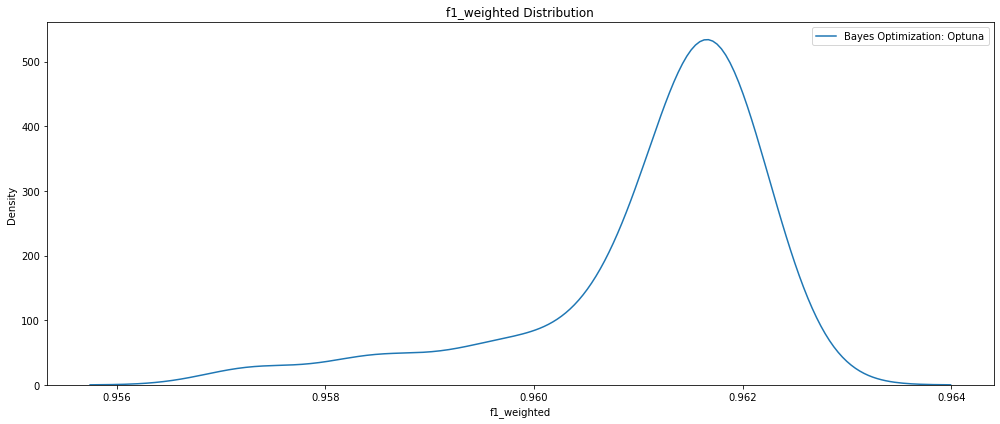

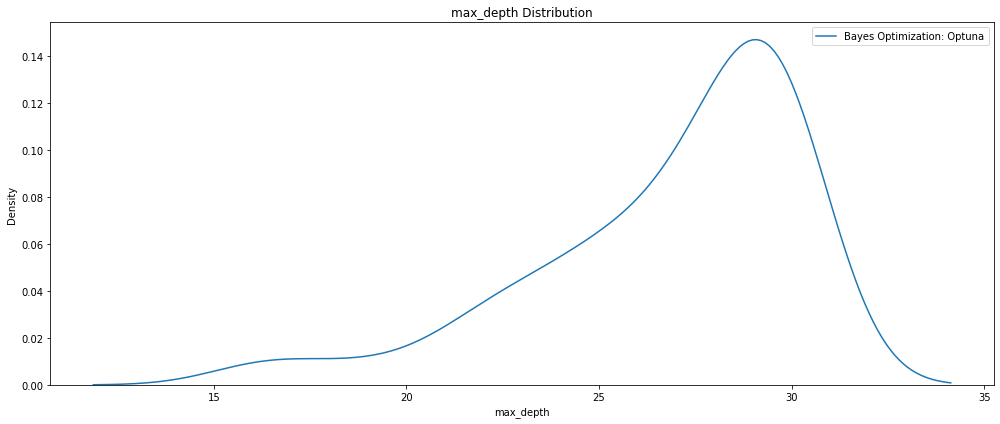

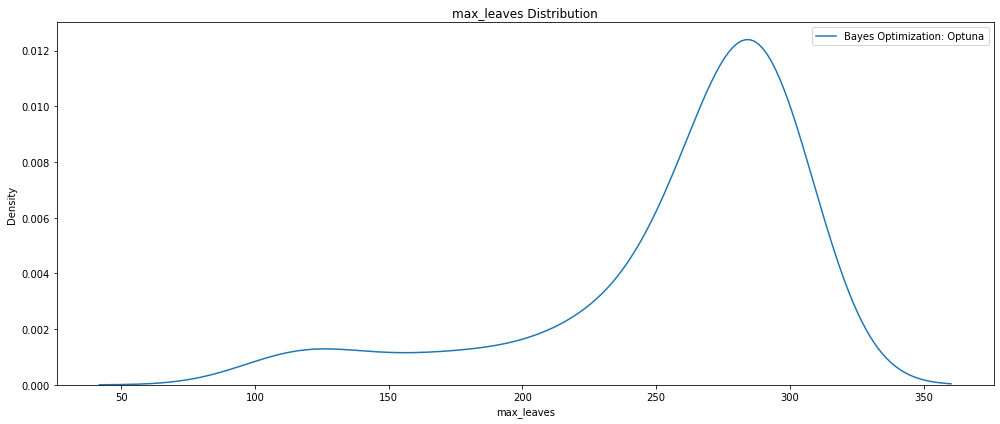

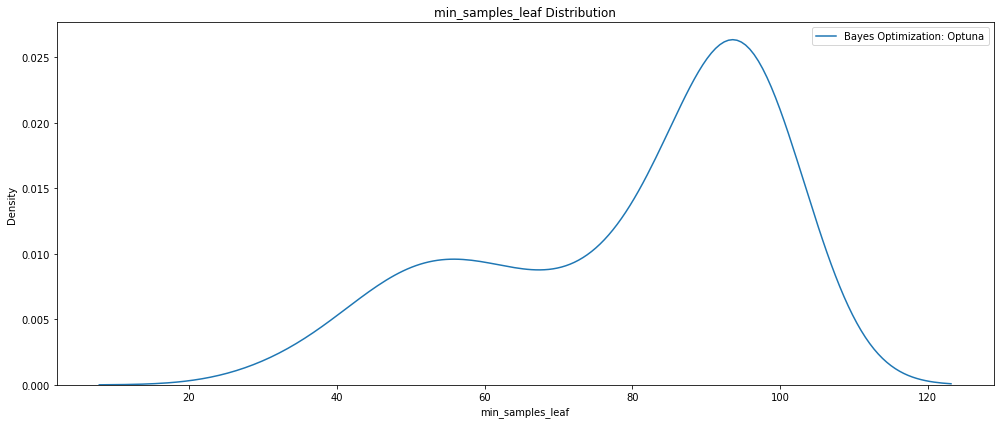

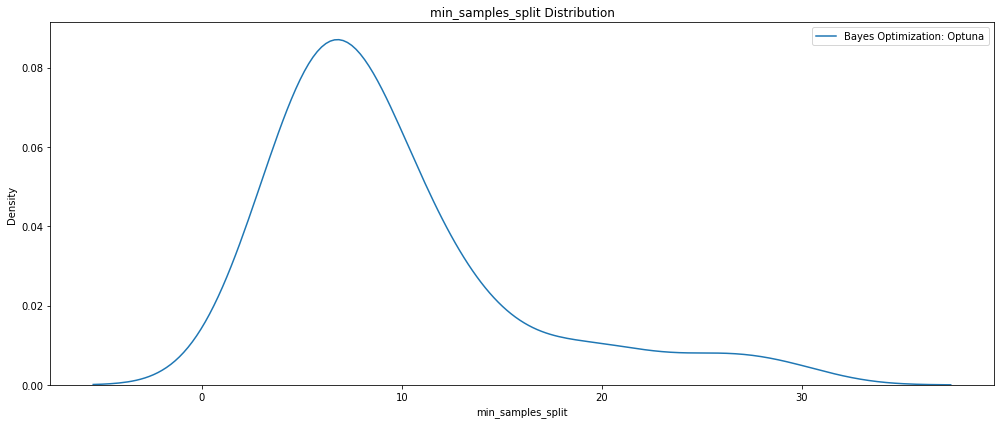

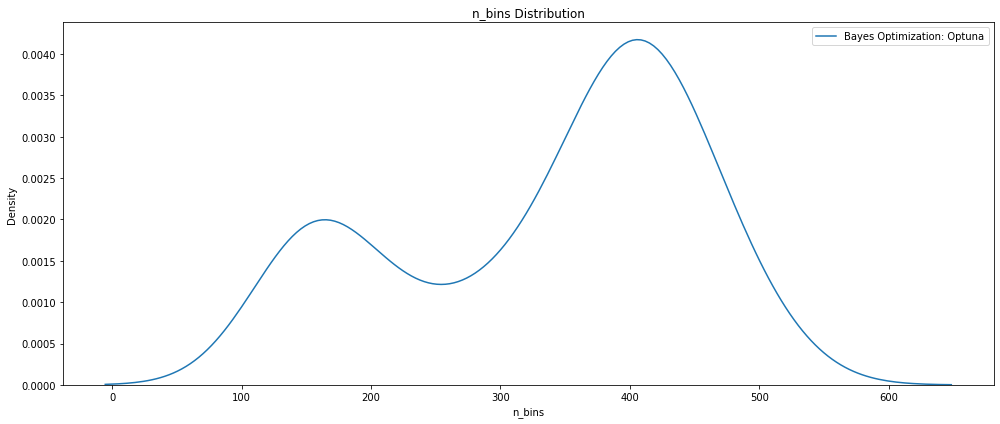

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

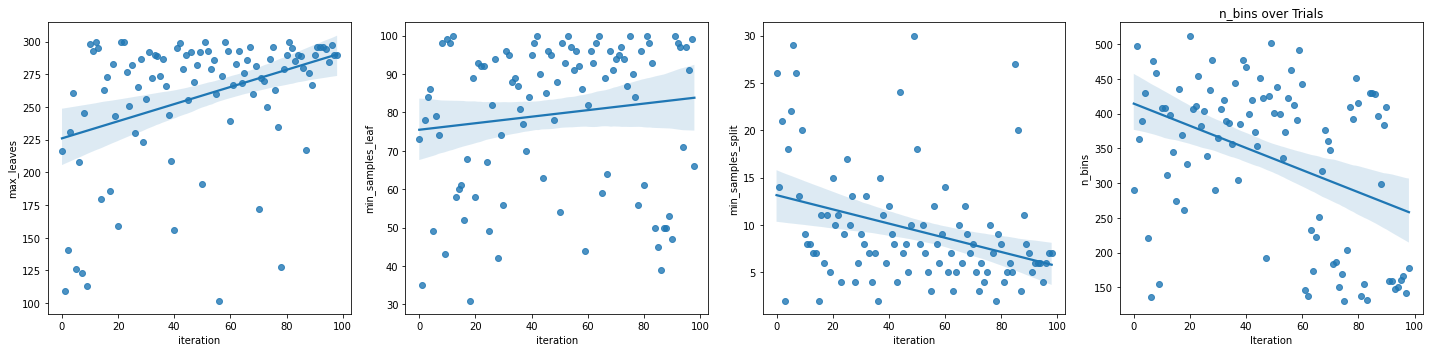

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_SMOTE_100_GPU_weightedF1.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 30,
 'max_leaves': 290,
 'min_samples_leaf': 50,
 'min_samples_split': 5,
 'n_bins': 429,
 'n_estimators': 349,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_SMOTE_trials100_GPU_weightedF1.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_SMOTE_trials100_GPU_weightedF1.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO SMOTE 100trials GPU')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for RF HPO SMOTE 100trials GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    377848
           1       0.99      0.73      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.98      0.86      0.91    432473
weighted avg       0.97      0.96      0.96    432473



Confusion matrix:
[[377394    454]
 [ 14718  39907]]


Accuracy score : 0.965
Precision score : 0.989
Recall score : 0.731
F1 score : 0.840


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 100 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 100 GPU trials optimization scores 0.86468 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    84
f1_weighted                            0.962609
datetime_start       2022-06-10 21:20:34.959732
datetime_complete    2022-06-10 21:22:12.035791
duration                 0 days 00:01:37.076059
max_depth                                  30.0
max_leaves                                290.0
min_samples_leaf                           50.0
min_samples_split                           5.0
n_bins                                    429.0
n_estimators                              349.0
state                                  COMPLETE
Name: 84, dtype: object


In [ ]:
################################################################################
######################         F1 Weighted        ##############################
######################         300 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_rf_optuna_SMOTE_300_weightedF1_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_SMOTE_300_GPU_weightedF1.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 200, 700) 
    max_depth = trial.suggest_int('max_depth', 15, 50) 
    max_leaves = trial.suggest_int('max_leaves', 200, 500) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_SMOTE_300_GPU_weightedF1.pkl'): 
      study = joblib.load('RF_Optuna_SMOTE_300_GPU_weightedF1.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=300,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest F1 Score', study.best_value)

Start Time           2022-06-10 21:56:22.711120
- Trial time: 175.6657125040001
- Trial weighted F1: 0.9636181890872407
######################################################
- Trial time: 138.49961793900002
- Trial weighted F1: 0.9612137596154531
######################################################
- Trial time: 125.56723892799891
- Trial weighted F1: 0.9629110942224379
######################################################
- Trial time: 168.4058559770001
- Trial weighted F1: 0.9631054408871421
######################################################
- Trial time: 59.66349466599968
- Trial weighted F1: 0.9598851160498307
######################################################
- Trial time: 108.42522560500038
- Trial weighted F1: 0.9615226633370094
######################################################
- Trial time: 160.59667172800073
- Trial weighted F1: 0.963519492357346
######################################################
- Trial time: 62.351742894999916
- Trial weighted F1: 0.9629

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'f1_weighted'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

trials_df = trials_df.sort_values('f1_weighted', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('RF_Optuna_SMOTE_300_GPU_weightedF1.csv', index=False)

     iteration  f1_weighted             datetime_start  \
220        220     0.965632 2022-06-11 03:13:42.577104   
216        216     0.965628 2022-06-11 03:08:25.307569   
194        194     0.965461 2022-06-11 02:37:59.957638   
276        276     0.965416 2022-06-11 04:29:25.955581   
210        210     0.965406 2022-06-11 02:58:42.478828   
..         ...          ...                        ...   
167        167     0.960960 2022-06-11 02:03:49.896582   
20          20     0.960872 2022-06-10 22:34:16.762588   
196        196     0.960795 2022-06-11 02:40:23.278627   
36          36     0.960725 2022-06-10 23:02:01.628640   
4            4     0.959885 2022-06-10 22:06:31.575737   

             datetime_complete               duration  max_depth  max_leaves  \
220 2022-06-11 03:15:02.911807 0 days 00:01:20.334703         47         477   
216 2022-06-11 03:09:41.741840 0 days 00:01:16.434271         31         484   
194 2022-06-11 02:39:11.540237 0 days 00:01:11.582599         2

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_SMOTE_300_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_SMOTE_300_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_SMOTE_300_GPU_weightedF1.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_SMOTE_300_GPU_weightedF1.html')
fig.show()

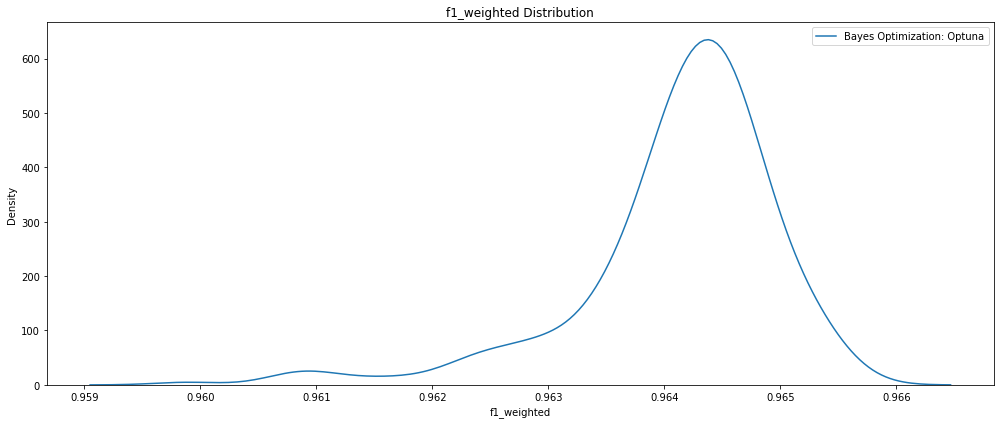

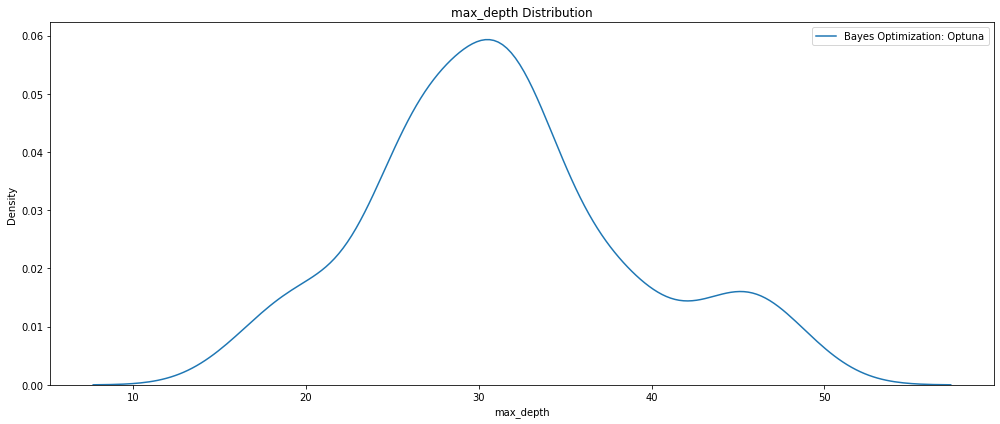

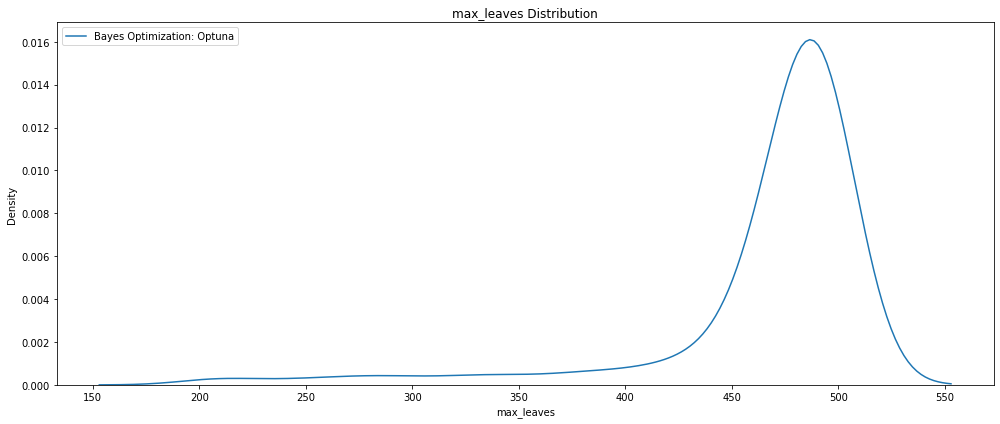

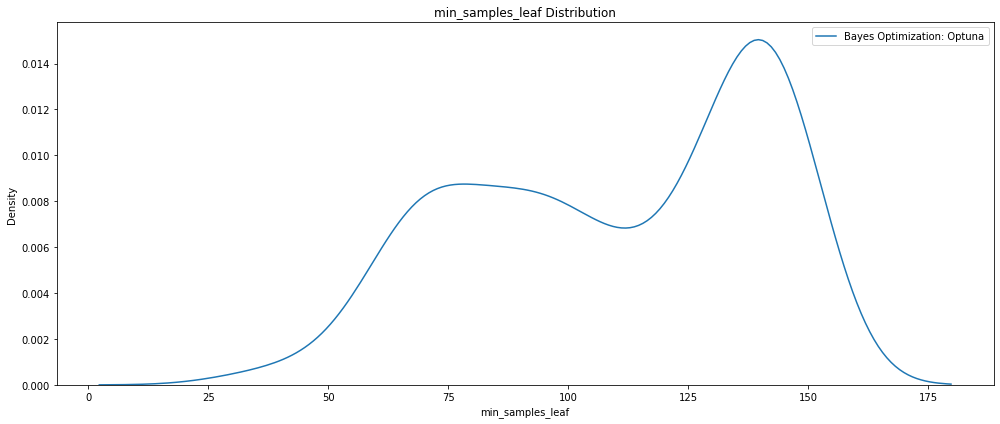

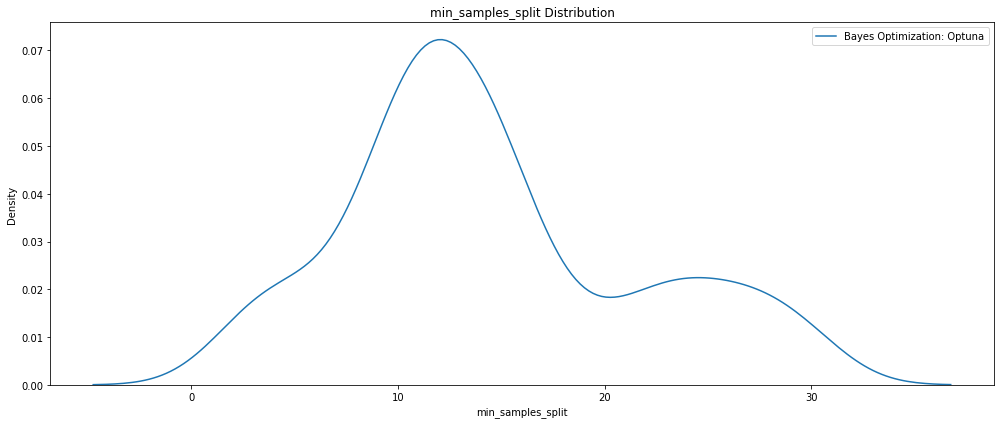

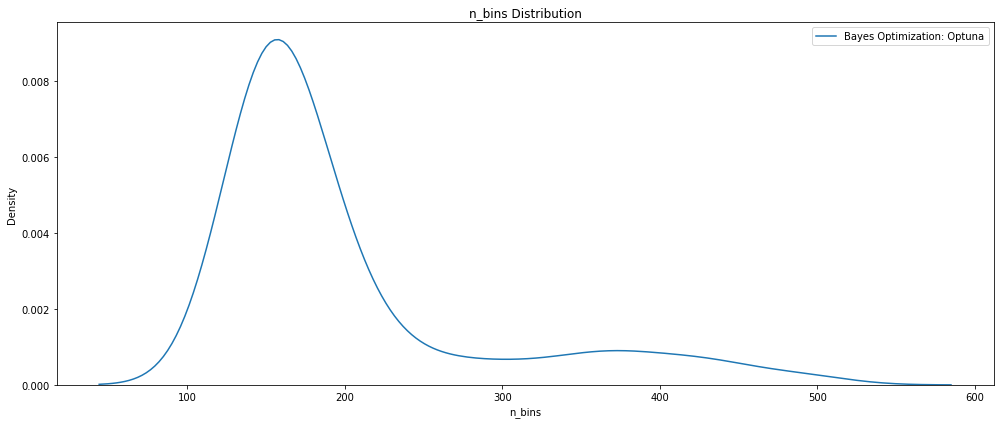

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

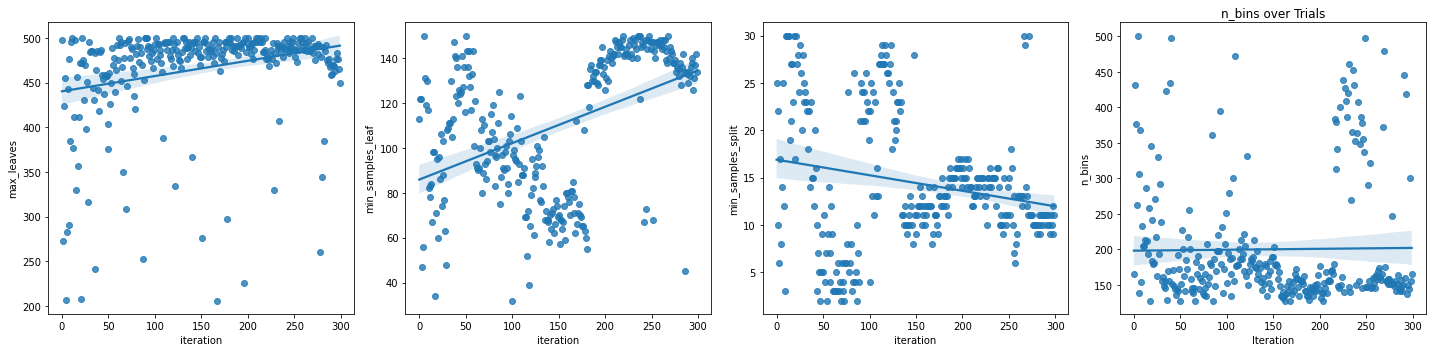

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_SMOTE_300_GPU_weightedF1.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_SMOTE_300_GPU_weightedF1.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 47,
 'max_leaves': 477,
 'min_samples_leaf': 141,
 'min_samples_split': 15,
 'n_bins': 149,
 'n_estimators': 288,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_SMOTE_trials300_GPU_weightedF1.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_SMOTE_trials300_GPU_weightedF1.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO SMOTE 300trials GPU')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for RF HPO SMOTE 300trials GPU


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    377848
           1       0.99      0.75      0.85     54625

    accuracy                           0.97    432473
   macro avg       0.98      0.88      0.92    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[377416    432]
 [ 13591  41034]]


Accuracy score : 0.968
Precision score : 0.990
Recall score : 0.751
F1 score : 0.854


In [ ]:
# Evaluate on the testing data 
print('The best model from Upsampling 300 GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from Upsampling 300 GPU trials optimization scores 0.87503 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   220
f1_weighted                            0.965632
datetime_start       2022-06-11 03:13:42.577104
datetime_complete    2022-06-11 03:15:02.911807
duration                 0 days 00:01:20.334703
max_depth                                    47
max_leaves                                  477
min_samples_leaf                            141
min_samples_split                            15
n_bins                                      149
n_estimators                                288
state                                  COMPLETE
Name: 220, dtype: object


In [ ]:
################################################################################
######################        Weighted ROC        ##############################
######################         100 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_rf_optuna_SMOTE_100_weightedROC_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, bootstrap=True,  
                   n_estimators=100, max_depth=16, 
                   max_leaves=100, min_samples_leaf=30, 
                   min_samples_split=10, n_bins=128): 
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Weighted ROC of the fitted model
    '''
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = RandomForestClassifier(random_state=seed_value, n_streams=1, 
                                  bootstrap=bootstrap, 
                                  n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_leaves=max_leaves, 
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, 
                                  n_bins=n_bins)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test.to_numpy(), y_pred.to_numpy(), 
                          average='weighted')
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial weighted ROC:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 24.638652096000442
- Trial weighted ROC: 0.8461048974108315
######################################################
Score with default parameters :  0.8461048974108315


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_SMOTE_100_GPU_ROCweighted.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) 
    max_depth = trial.suggest_int('max_depth', 16, 30) 
    max_leaves = trial.suggest_int('max_leaves', 100, 300) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_SMOTE_100_GPU_ROCweighted.pkl'): 
      study = joblib.load('RF_Optuna_SMOTE_100_GPU_ROCweighted.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted score', study.best_value)

Start Time           2022-06-11 05:05:08.996349
- Trial time: 120.01715760400111
- Trial weighted ROC: 0.8554418228884019
######################################################
- Trial time: 52.84329947299557
- Trial weighted ROC: 0.8516698663034357
######################################################
- Trial time: 126.23798793199967
- Trial weighted ROC: 0.8544326330392225
######################################################
- Trial time: 127.36597318900021
- Trial weighted ROC: 0.8550527556829481
######################################################
- Trial time: 125.59946214800584
- Trial weighted ROC: 0.8534394468406339
######################################################
- Trial time: 46.939093426997715
- Trial weighted ROC: 0.8502054450769665
######################################################
- Trial time: 59.3878206340014
- Trial weighted ROC: 0.8587154866967439
######################################################
- Trial time: 72.94104651600355
- Trial weighted ROC

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

trials_df = trials_df.sort_values('roc_weighted', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('RF_Optuna_SMOTE_100_GPU_ROCweighted.csv', index=False)

    iteration  roc_weighted             datetime_start  \
83         83      0.864731 2022-06-11 06:58:01.609643   
84         84      0.864430 2022-06-11 06:59:19.739424   
41         41      0.864360 2022-06-11 06:01:23.771092   
86         86      0.863853 2022-06-11 07:01:46.635790   
28         28      0.863827 2022-06-11 05:43:47.744671   
..        ...           ...                        ...   
36         36      0.853264 2022-06-11 05:53:11.147856   
1           1      0.851670 2022-06-11 05:07:09.160965   
17         17      0.851171 2022-06-11 05:30:03.273462   
56         56      0.850892 2022-06-11 06:21:07.647403   
5           5      0.850205 2022-06-11 05:14:21.931195   

            datetime_complete               duration  max_depth  max_leaves  \
83 2022-06-11 06:59:19.739238 0 days 00:01:18.129595         23         289   
84 2022-06-11 07:00:35.428077 0 days 00:01:15.688653         24         288   
41 2022-06-11 06:02:45.515866 0 days 00:01:21.744774         23   

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

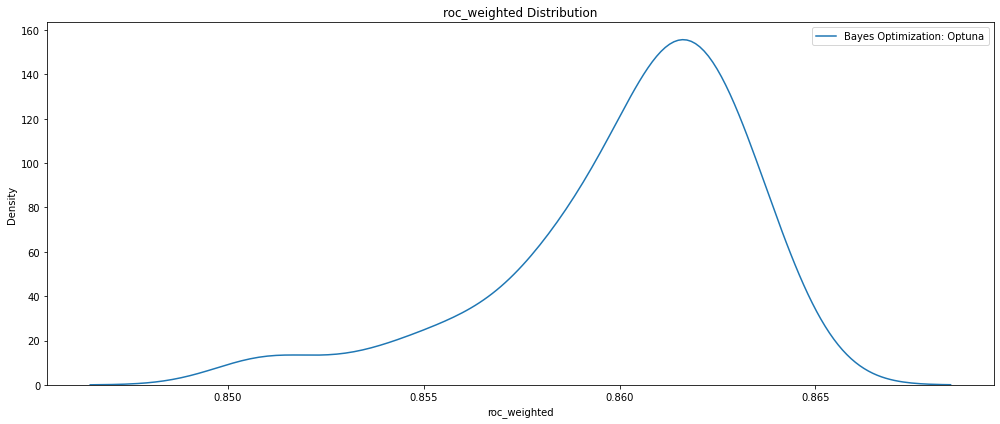

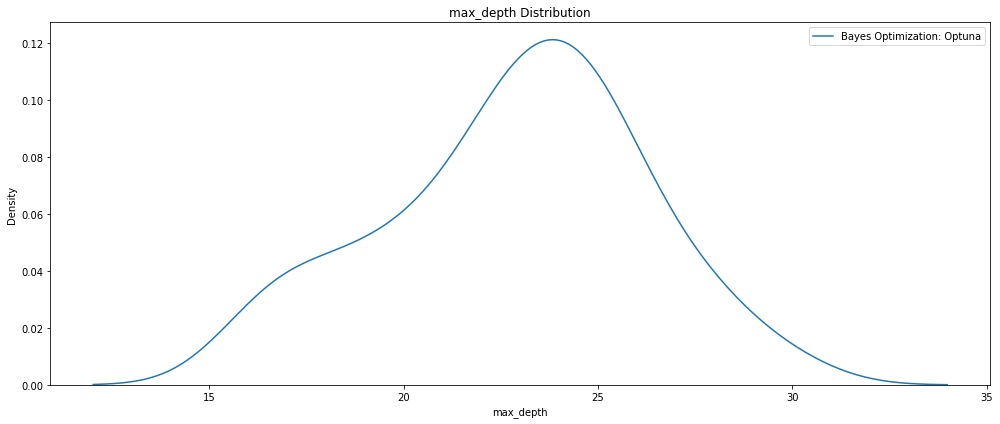

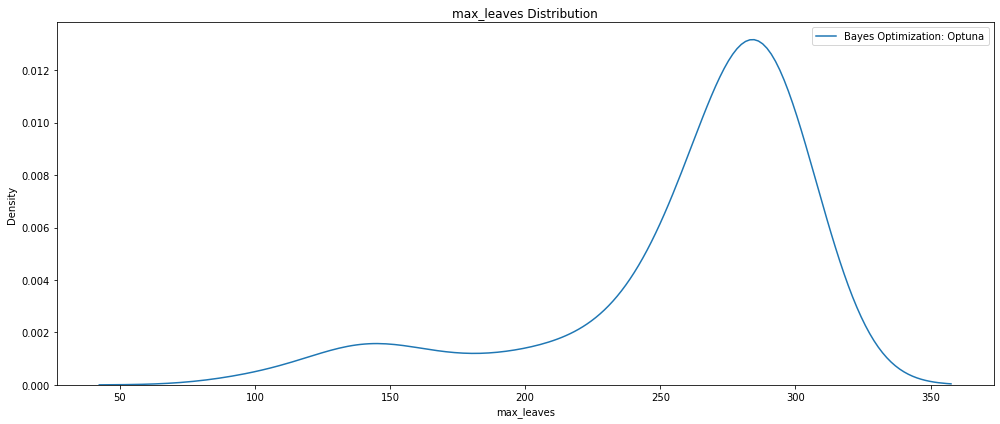

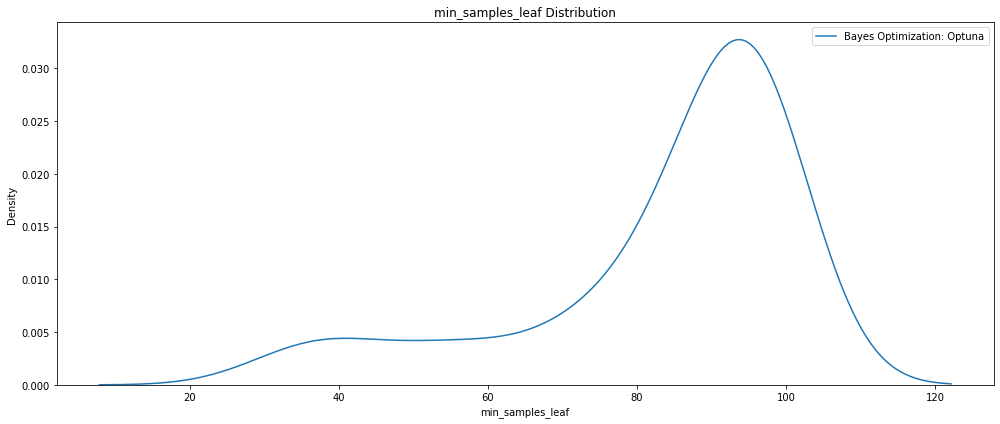

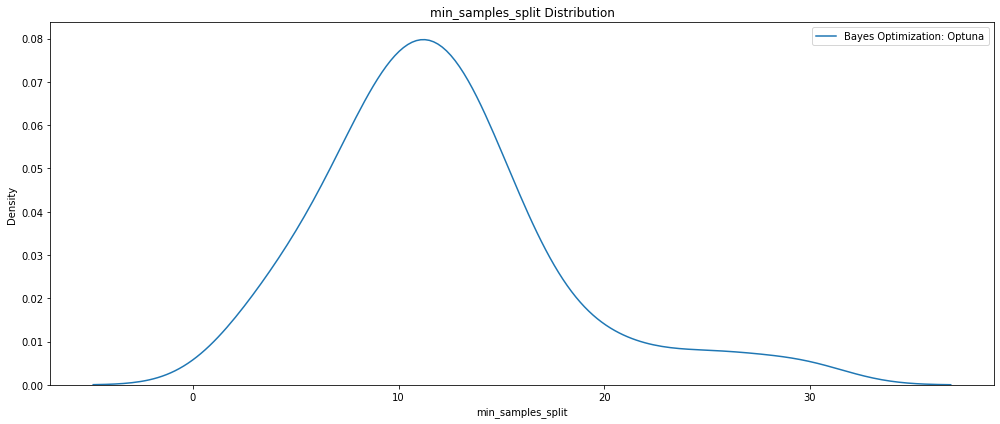

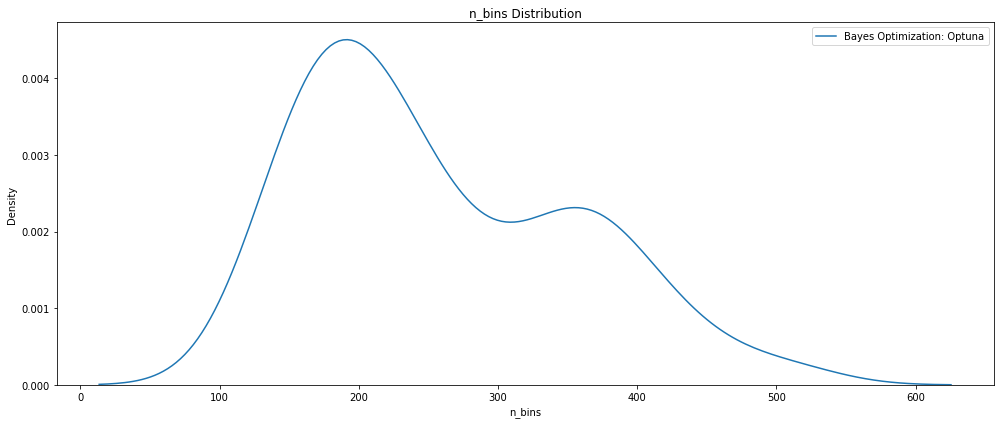

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

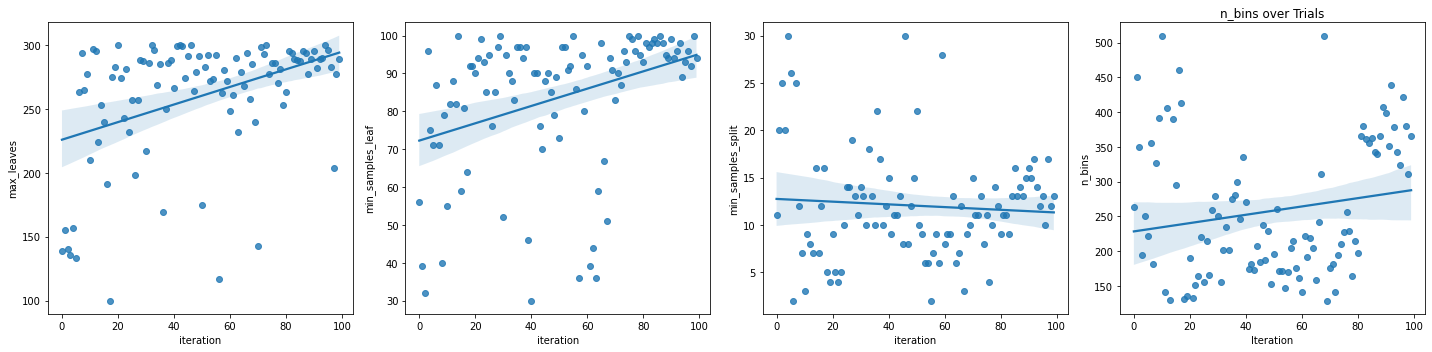

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_SMOTE_100_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 23,
 'max_leaves': 289,
 'min_samples_leaf': 98,
 'min_samples_split': 9,
 'n_bins': 361,
 'n_estimators': 281,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
# Set up features and target
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_SMOTE_trials100_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_SMOTESMOTE_trials100_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO SMOTE 100trials GPU ROCweighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for RF HPO SMOTE 100trials GPU ROCweighted


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    377848
           1       0.99      0.73      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.98      0.86      0.91    432473
weighted avg       0.97      0.96      0.96    432473



Confusion matrix:
[[377370    478]
 [ 14709  39916]]


Accuracy score : 0.965
Precision score : 0.988
Recall score : 0.731
F1 score : 0.840


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 100 ROCweighted GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 100 ROCweighted GPU trials optimization scores 0.86473 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    83
roc_weighted                           0.864731
datetime_start       2022-06-11 06:58:01.609643
datetime_complete    2022-06-11 06:59:19.739238
duration                 0 days 00:01:18.129595
max_depth                                    23
max_leaves                                  289
min_samples_leaf                             98
min_samples_split                             9
n_bins                                      361
n_estimators                                281
state                                  COMPLETE
Name: 83, dtype: object


In [ ]:
################################################################################
######################        Weighted ROC        ##############################
######################         300 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_rf_optuna_SMOTE_300_weightedROC_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_SMOTE_300_GPU_ROCweighted.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 200, 700) 
    max_depth = trial.suggest_int('max_depth', 15, 50) 
    max_leaves = trial.suggest_int('max_leaves', 200, 500) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_SMOTE_300_GPU_ROCweighted.pkl'): 
      study = joblib.load('RF_Optuna_SMOTE_300_GPU_ROCweighted.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=300,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest ROCweighted score', study.best_value)

Start Time           2022-06-11 07:20:24.425924
- Trial time: 186.16344315400056
- Trial weighted ROC: 0.856910418713769
######################################################
- Trial time: 76.59222927700466
- Trial weighted ROC: 0.8668864095920402
######################################################
- Trial time: 85.11452702600218
- Trial weighted ROC: 0.8688098200058363
######################################################
- Trial time: 71.28401086899976
- Trial weighted ROC: 0.8603901052410649
######################################################
- Trial time: 82.13462356899981
- Trial weighted ROC: 0.8710923080616437
######################################################
- Trial time: 53.91002307999588
- Trial weighted ROC: 0.8594308784562287
######################################################
- Trial time: 133.97431718299777
- Trial weighted ROC: 0.8659781474487314
######################################################
- Trial time: 175.6581874129988
- Trial weighted ROC: 0

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'roc_weighted'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

trials_df = trials_df.sort_values('roc_weighted', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('RF_Optuna_SMOTE_300_GPU_ROCweighted.csv', index=False)

     iteration  roc_weighted             datetime_start  \
217        217      0.875139 2022-06-11 12:40:58.361808   
153        153      0.874570 2022-06-11 11:14:35.774597   
232        232      0.874199 2022-06-11 13:00:57.925309   
251        251      0.874063 2022-06-11 13:26:03.237072   
155        155      0.873940 2022-06-11 11:17:08.764039   
..         ...           ...                        ...   
128        128      0.859333 2022-06-11 10:39:40.581825   
7            7      0.859190 2022-06-11 07:31:54.854281   
50          50      0.858670 2022-06-11 08:49:58.757940   
0            0      0.856910 2022-06-11 07:20:24.427481   
299        299           NaN 2022-06-11 14:34:28.887637   

             datetime_complete               duration  max_depth  max_leaves  \
217 2022-06-11 12:42:17.683103 0 days 00:01:19.321295       41.0       492.0   
153 2022-06-11 11:15:55.282463 0 days 00:01:19.507866       47.0       500.0   
232 2022-06-11 13:02:18.047276 0 days 00:01:20.1219

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_SMOTE_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_SMOTE_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_SMOTE_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_SMOTE_300_GPU_ROCweighted.html')
fig.show()

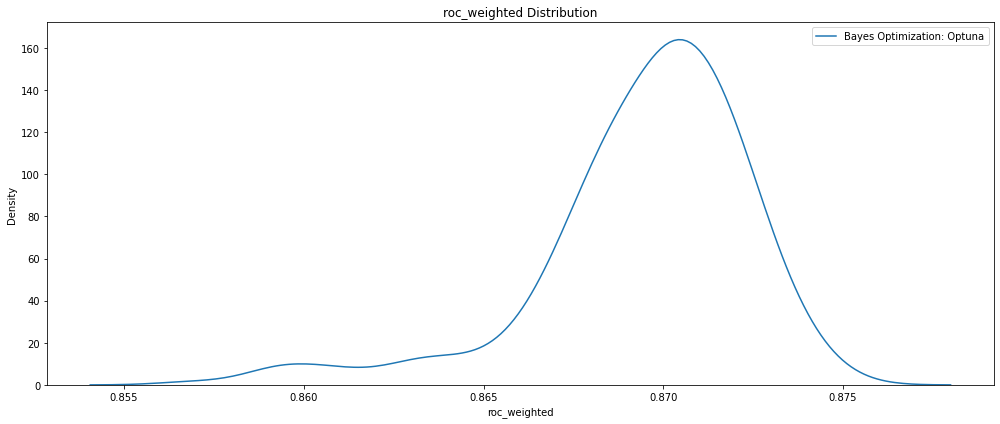

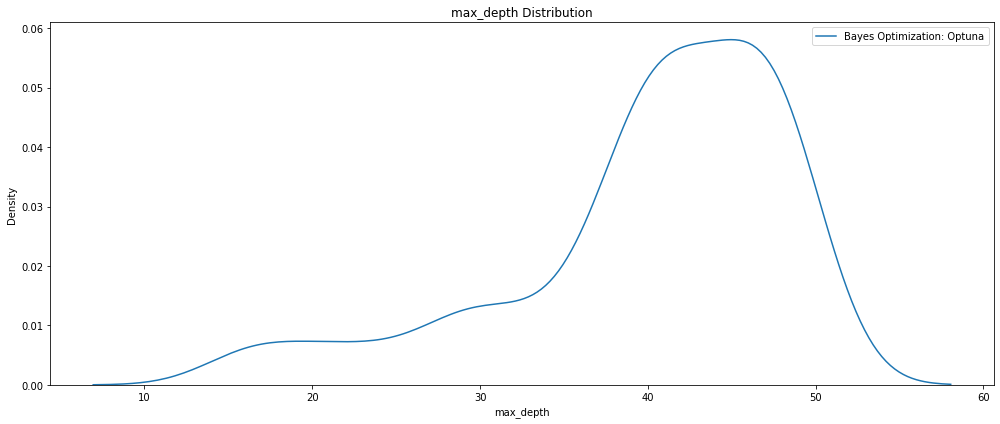

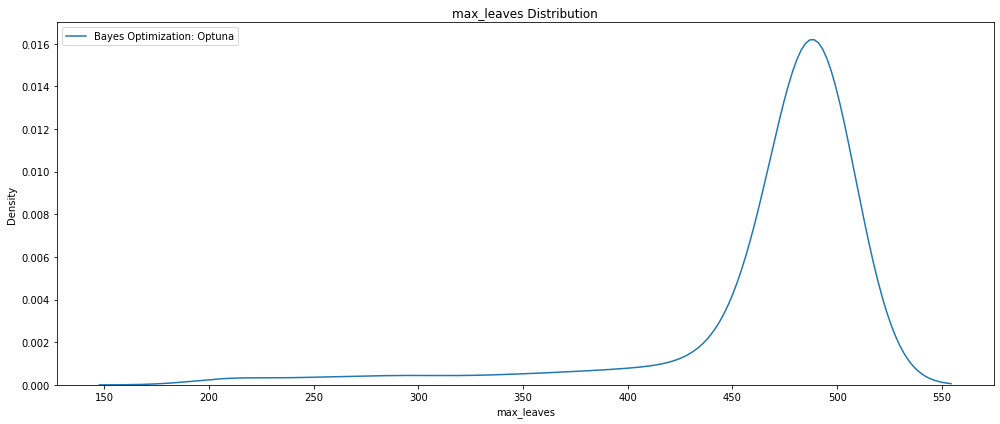

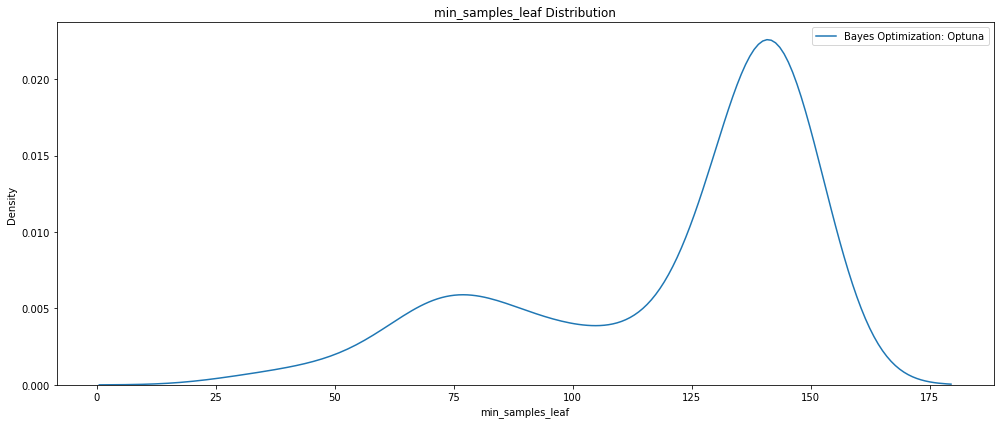

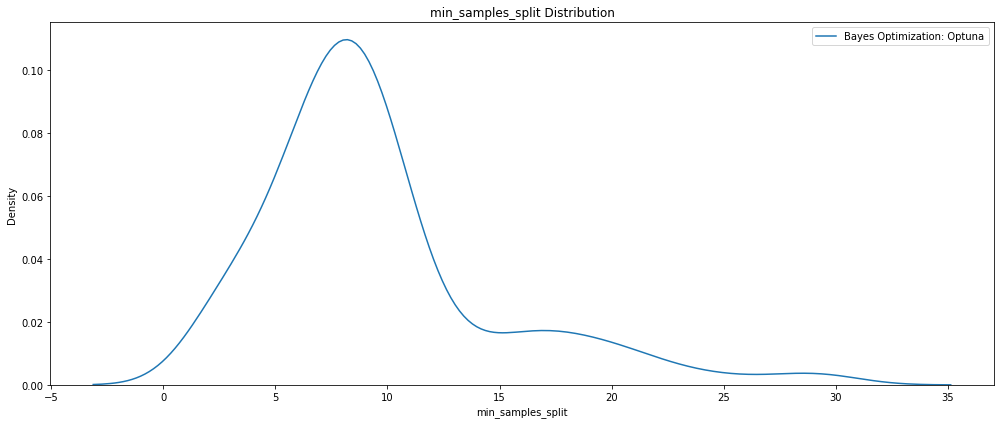

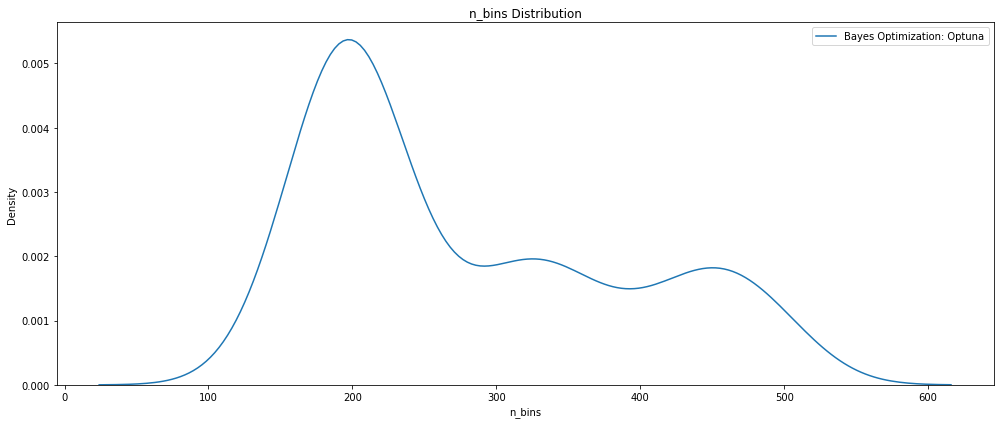

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

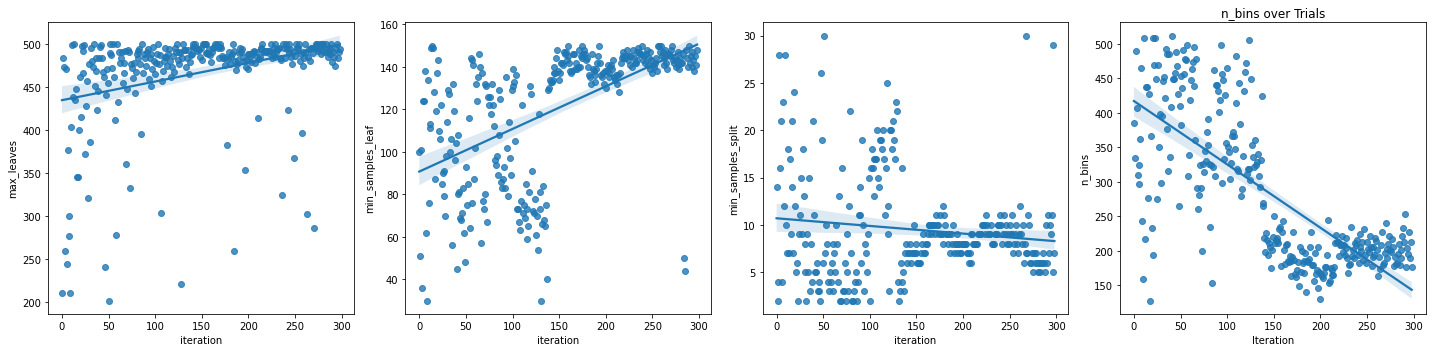

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/RF/Optuna/Model_Explanations/

[Errno 2] No such file or directory: '/content/drive/MyDrive/LoanStatus/RF/Optuna/Model_Explanations/'
/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_SMOTE_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_SMOTE_300_GPU_ROCweighted.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 41,
 'max_leaves': 492,
 'min_samples_leaf': 144,
 'min_samples_split': 9,
 'n_bins': 223,
 'n_estimators': 280,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
# Set up features and target
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_SMOTE_trials300_GPU_ROCweighted.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_SMOTE_trials300_GPU_ROCweighted.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO SMOTE 300trials GPU ROCweighted')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for RF HPO SMOTE 300trials GPU ROCweighted


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    377848
           1       0.99      0.75      0.85     54625

    accuracy                           0.97    432473
   macro avg       0.98      0.88      0.92    432473
weighted avg       0.97      0.97      0.97    432473



Confusion matrix:
[[377481    367]
 [ 13588  41037]]


Accuracy score : 0.968
Precision score : 0.991
Recall score : 0.751
F1 score : 0.855


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 300 ROCweighted GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 300 ROCweighted GPU trials optimization scores 0.87514 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   217
roc_weighted                           0.875139
datetime_start       2022-06-11 12:40:58.361808
datetime_complete    2022-06-11 12:42:17.683103
duration                 0 days 00:01:19.321295
max_depth                                  41.0
max_leaves                                492.0
min_samples_leaf                          144.0
min_samples_split                           9.0
n_bins                                    223.0
n_estimators                              280.0
state                                  COMPLETE
Name: 217, dtype: object


In [ ]:
################################################################################
######################        Recall Score        ##############################
######################         100 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_rf_optuna_SMOTE_100_Recall_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, bootstrap=True,  
                   n_estimators=100, max_depth=16, 
                   max_leaves=100, min_samples_leaf=30, 
                   min_samples_split=10, n_bins=128): 
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Recall score of the fitted model
    '''
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = RandomForestClassifier(random_state=seed_value, n_streams=1, 
                                  bootstrap=bootstrap, 
                                  n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_leaves=max_leaves, 
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, 
                                  n_bins=n_bins)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = recall_score(y_test.to_numpy(), y_pred.to_numpy())
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial recall score:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 24.307917178000025
- Trial recall score: 0.6964027459954233
######################################################
Score with default parameters :  0.6964027459954233


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_SMOTE_100_GPU_Recall.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) 
    max_depth = trial.suggest_int('max_depth', 16, 30) 
    max_leaves = trial.suggest_int('max_leaves', 100, 300) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_SMOTE_100_GPU_Recall.pkl'): 
      study = joblib.load('RF_Optuna_SMOTE_100_GPU_Recall.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=101,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall score', study.best_value)

Start Time           2022-06-11 20:08:24.050736
- Trial time: 127.93792282100003
- Trial recall score: 0.7127688787185354
######################################################
..dask_optuna             :  128.1594
Start Time           2022-06-11 20:08:24.050736
End Time             2022-06-11 20:10:32.210270
0:02:08


Number of finished trials: 101
Best trial: {'n_estimators': 481, 'max_depth': 22, 'max_leaves': 300, 'min_samples_leaf': 43, 'min_samples_split': 2, 'n_bins': 321}
Highest Recall score 0.7304347826086957


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

trials_df = trials_df.sort_values('recall', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('RF_Optuna_SMOTE_100_GPU_Recall.csv', index=False)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

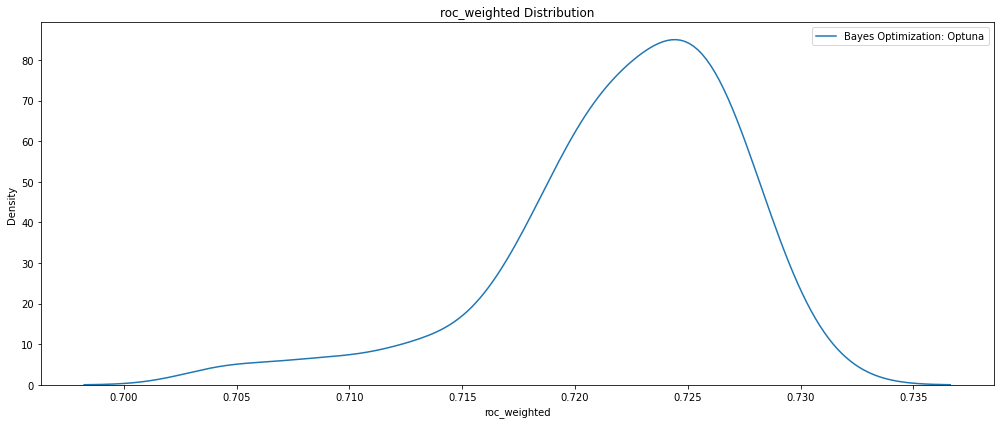

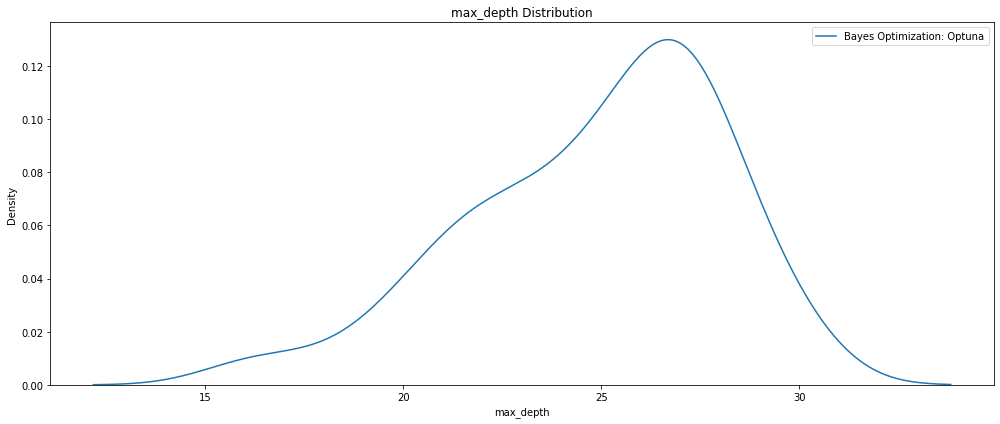

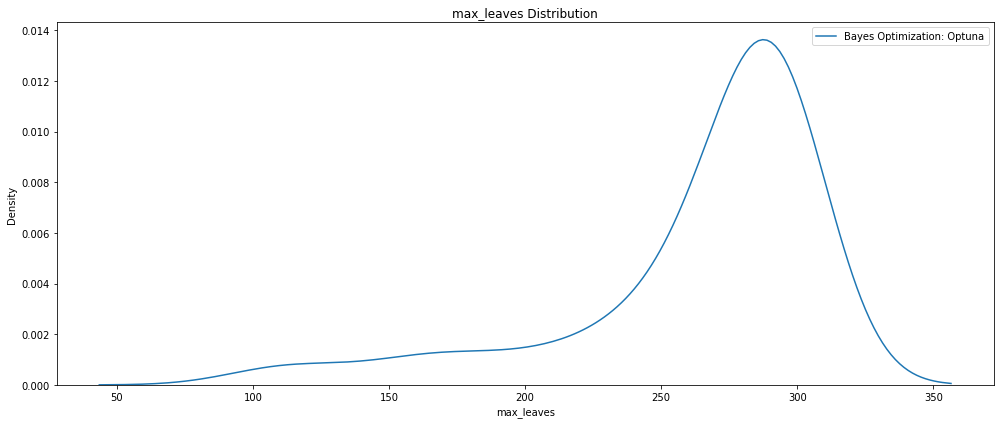

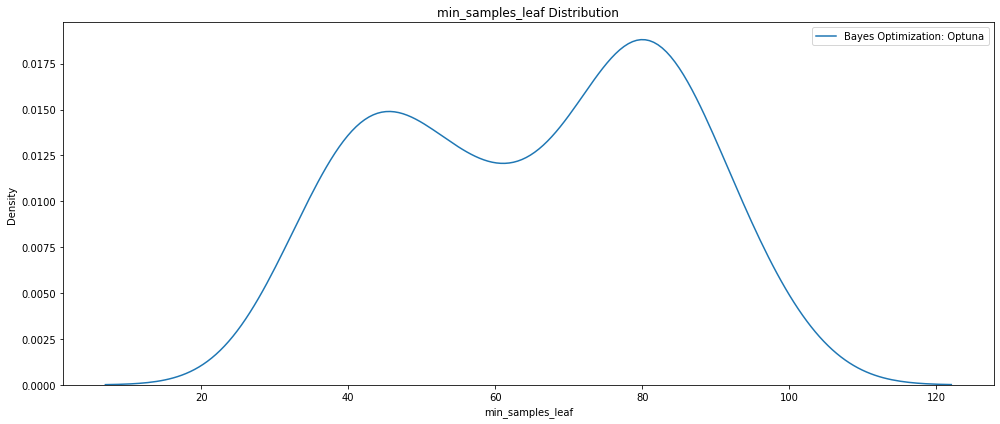

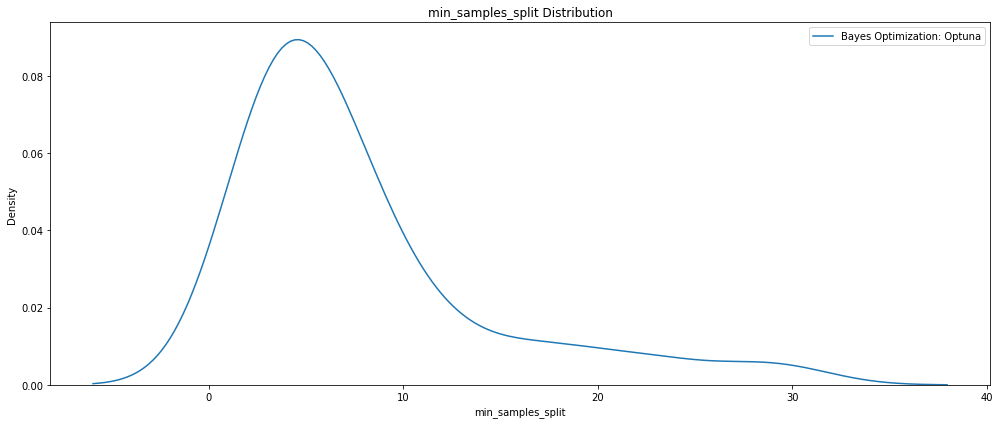

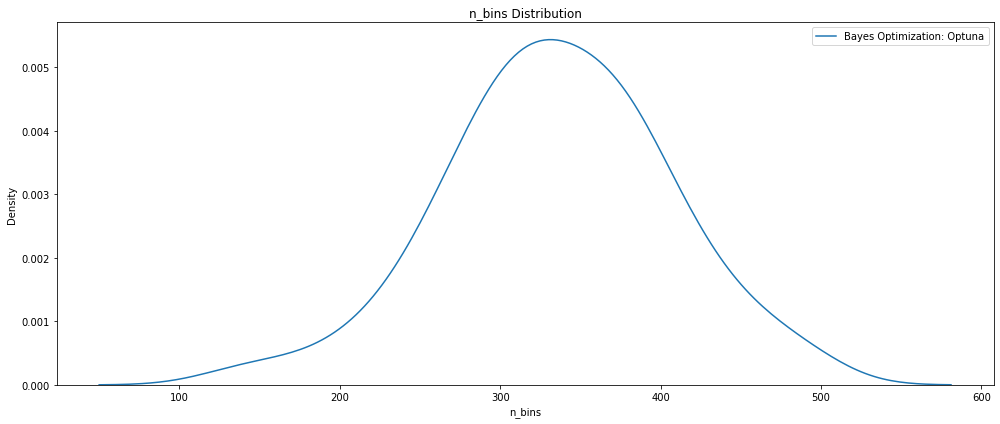

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

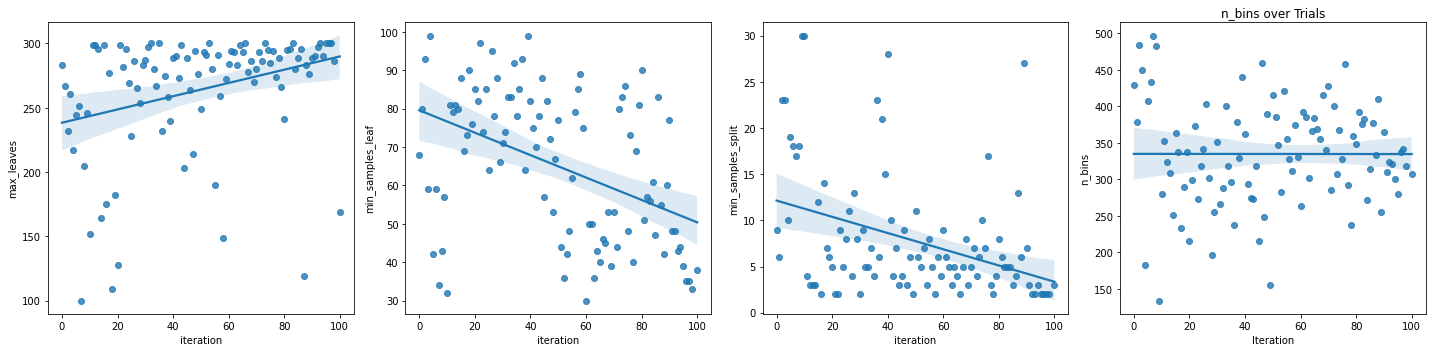

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_SMOTE_100_GPU_Recall.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 22,
 'max_leaves': 300,
 'min_samples_leaf': 43,
 'min_samples_split': 2,
 'n_bins': 321,
 'n_estimators': 481,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_SMOTE_trials100_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_SMOTE_trials100_GPU_Recall.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO SMOTE 100trials GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for RF HPO SMOTE 100trials GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    377848
           1       0.99      0.73      0.84     54625

    accuracy                           0.96    432473
   macro avg       0.97      0.86      0.91    432473
weighted avg       0.97      0.96      0.96    432473



Confusion matrix:
[[377342    506]
 [ 14725  39900]]


Accuracy score : 0.965
Precision score : 0.987
Recall score : 0.730
F1 score : 0.840


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 100 Recall GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 100 Recall GPU trials optimization scores 0.86455 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    93
roc_weighted                           0.730435
datetime_start       2022-06-11 19:50:05.651707
datetime_complete    2022-06-11 19:52:18.560243
duration                 0 days 00:02:12.908536
max_depth                                  22.0
max_leaves                                300.0
min_samples_leaf                           43.0
min_samples_split                           2.0
n_bins                                    321.0
n_estimators                              481.0
state                                  COMPLETE
Name: 93, dtype: object


In [ ]:
################################################################################
######################        Recall Score        ##############################
######################         300 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_rf_optuna_SMOTE_300_Recall_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_SMOTE_300_GPU_Recall.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 400, 700) 
    max_depth = trial.suggest_int('max_depth', 20, 40) 
    max_leaves = trial.suggest_int('max_leaves', 280, 500) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 35, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20) 
    n_bins = trial.suggest_int('n_bins', 270, 430)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_SMOTE_300_GPU_Recall.pkl'): 
      study = joblib.load('RF_Optuna_SMOTE_300_GPU_Recall.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=300,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Recall score', study.best_value)

Start Time           2022-06-11 20:21:10.732027
- Trial time: 165.63487723100116
- Trial recall score: 0.7240274599542335
######################################################
- Trial time: 170.70477485299853
- Trial recall score: 0.7343890160183066
######################################################
- Trial time: 160.7860069849994
- Trial recall score: 0.7272311212814645
######################################################
- Trial time: 164.21475030500005
- Trial recall score: 0.7340961098398169
######################################################
- Trial time: 179.5565085069993
- Trial recall score: 0.7230755148741419
######################################################
- Trial time: 197.4626000870012
- Trial recall score: 0.7271395881006865
######################################################
- Trial time: 131.29704355000104
- Trial recall score: 0.7332356979405035
######################################################
- Trial time: 144.69557282000096
- Trial recall scor

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'recall'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

trials_df = trials_df.sort_values('recall', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('RF_Optuna_SMOTE_300_GPU_Recall.csv', index=False)

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_SMOTE_300_GPU_Recall.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_SMOTE_300_GPU_Recall.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_SMOTE_300_GPU_Recall.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_SMOTE_300_GPU_Recall.html')
fig.show()

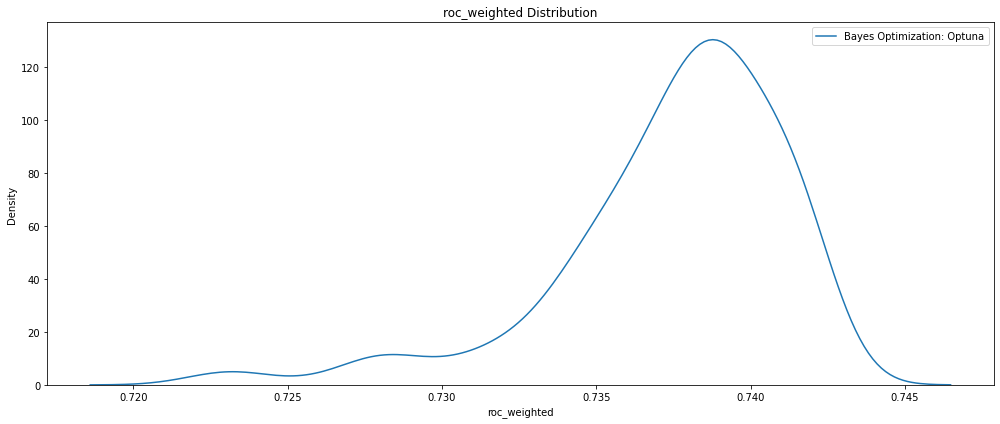

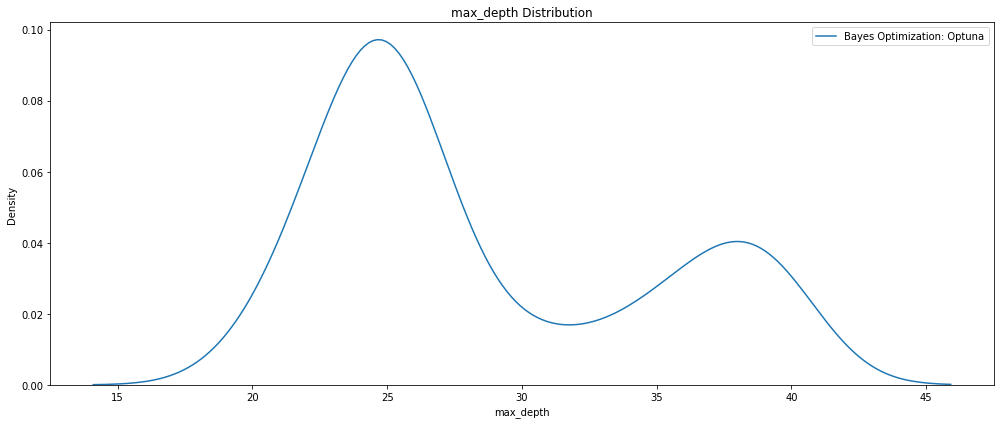

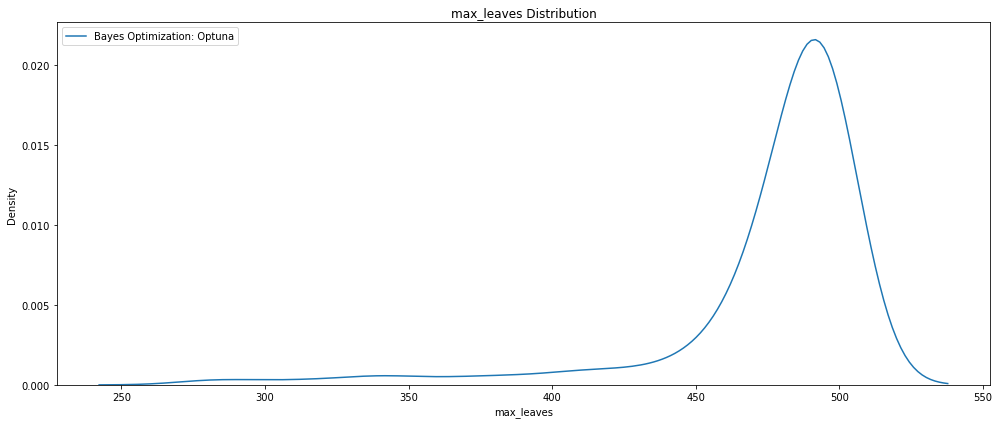

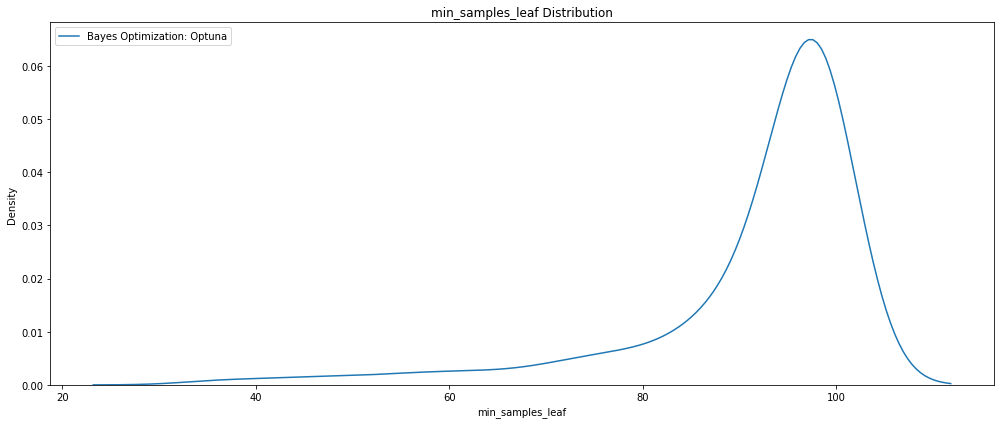

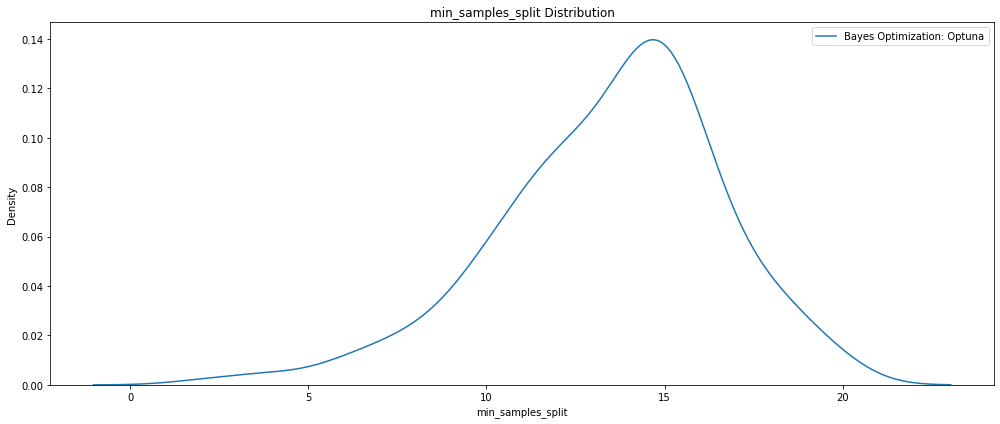

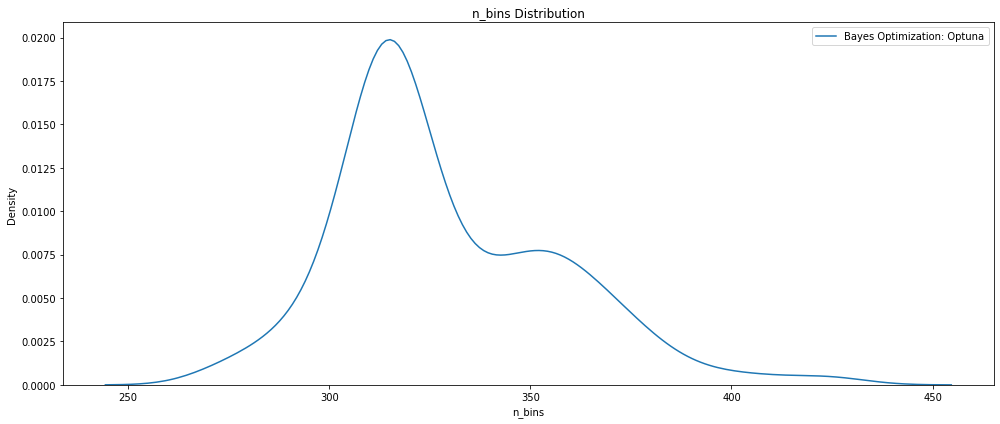

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

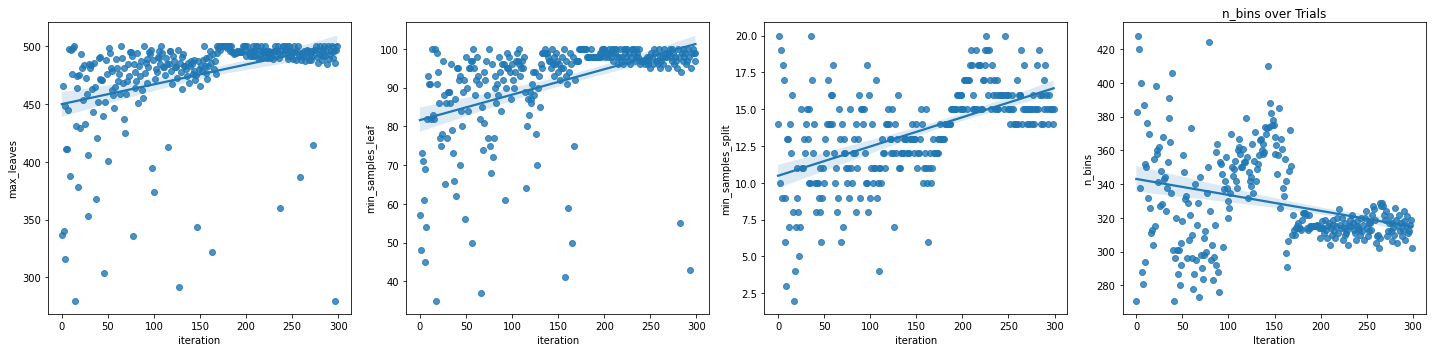

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_SMOTE_300_GPU_Recall.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_SMOTE_300_GPU_Recall.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 26,
 'max_leaves': 494,
 'min_samples_leaf': 98,
 'min_samples_split': 15,
 'n_bins': 314,
 'n_estimators': 496,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_SMOTE_trials300_GPU_Recall.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_SMOTE_trials300_GPU_Recall.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO SMOTE 300trials GPU Recall')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for RF HPO SMOTE 300trials GPU Recall


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    377848
           1       0.99      0.74      0.85     54625

    accuracy                           0.97    432473
   macro avg       0.98      0.87      0.92    432473
weighted avg       0.97      0.97      0.96    432473



Confusion matrix:
[[377496    352]
 [ 14046  40579]]


Accuracy score : 0.967
Precision score : 0.991
Recall score : 0.743
F1 score : 0.849


In [ ]:
# Evaluate on the testing data 
# Evaluate predictive probability on the testing data 
#preds = best_model.predict_proba(X_test)[:, 1]
print('The best model from SMOTE 300 Recall GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 300 Recall GPU trials optimization scores 0.87097 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   188
roc_weighted                           0.742865
datetime_start       2022-06-12 03:43:45.312933
datetime_complete    2022-06-12 03:46:08.173257
duration                 0 days 00:02:22.860324
max_depth                                    26
max_leaves                                  494
min_samples_leaf                             98
min_samples_split                            15
n_bins                                      314
n_estimators                                496
state                                  COMPLETE
Name: 188, dtype: object


In [ ]:
################################################################################
######################      Precision Score       ##############################
######################         100 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_rf_optuna_SMOTE_100_Precision_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define function to train/evaluate the model
def train_and_eval(X_param, y_param, bootstrap=True,  
                   n_estimators=100, max_depth=16, 
                   max_leaves=100, min_samples_leaf=30, 
                   min_samples_split=10, n_bins=128): 
    '''
        Partition data into train/test sets, train and evaluate the model
        for the given parameters.
        
        Params
        ______
        
        X_param:  DataFrame. 
                  The data to use for training and testing. 
        y_param:  Series. 
                  The label for training

        Returns
        score: Precision of the fitted model
    '''
    X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')

    X_train = cudf.get_dummies(X_train, columns=cat_cols) 
    X_train = X_train.astype('float32')

    X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

    X_test = cudf.get_dummies(X_test, columns=cat_cols1)
    X_test = X_test.astype('float32')

    model = RandomForestClassifier(random_state=seed_value, n_streams=1, 
                                  bootstrap=bootstrap, 
                                  n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  max_leaves=max_leaves, 
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, 
                                  n_bins=n_bins)
    
    # Start timer for each trial
    start = timer()

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = precision_score(y_test.to_numpy(), y_pred.to_numpy())
     
    run_time = timer() - start

    print('- Trial time:', run_time) 
    print('- Trial precision score:', score)
    print('######################################################')

    return score

In [ ]:
print('Score with default parameters : ', train_and_eval(X_train, y_train))

- Trial time: 28.78847638100001
- Trial precision score: 0.9778831778110016
######################################################
Score with default parameters :  0.9778831778110016


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_SMOTE_100_GPU_Precision.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) 
    max_depth = trial.suggest_int('max_depth', 16, 30) 
    max_leaves = trial.suggest_int('max_leaves', 100, 300) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 30, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 30) 
    n_bins = trial.suggest_int('n_bins', 128, 512)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_SMOTE_100_GPU_Precision.pkl'): 
      study = joblib.load('RF_Optuna_SMOTE_100_GPU_Precision.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=100,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision score', study.best_value)

Start Time           2022-06-14 13:55:34.405907
- Trial time: 44.064070399
- Trial precision score: 0.9865934462577668
######################################################
- Trial time: 68.19092495200016
- Trial precision score: 0.9872230834625194
######################################################
- Trial time: 63.776350356999956
- Trial precision score: 0.9893260140286673
######################################################
- Trial time: 84.24130854700002
- Trial precision score: 0.9877119069114254
######################################################
- Trial time: 60.41063583599998
- Trial precision score: 0.9891391996774519
######################################################
- Trial time: 94.44891306199997
- Trial precision score: 0.9877081379729833
######################################################
- Trial time: 44.519812270999864
- Trial precision score: 0.9920886075949367
######################################################
- Trial time: 114.74291040700018
- Tri

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

trials_df = trials_df.sort_values('precision', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('RF_Optuna_SMOTE_100_GPU_Precision.csv', index=False)

    iteration  precision             datetime_start  \
91         91   0.992927 2022-06-14 15:11:48.099539   
92         92   0.992821 2022-06-14 15:12:21.894044   
78         78   0.992758 2022-06-14 15:01:11.387563   
76         76   0.992728 2022-06-14 15:00:01.952273   
99         99   0.992428 2022-06-14 15:17:00.534012   
..        ...        ...                        ...   
10         10   0.983423 2022-06-14 14:08:24.186708   
7           7   0.983119 2022-06-14 14:03:15.209899   
49         49   0.982627 2022-06-14 14:40:04.666931   
30         30   0.982316 2022-06-14 14:25:24.609358   
47         47   0.980956 2022-06-14 14:38:38.889246   

            datetime_complete               duration  max_depth  max_leaves  \
91 2022-06-14 15:12:21.893901 0 days 00:00:33.794362         27         287   
92 2022-06-14 15:12:57.452126 0 days 00:00:35.558082         27         271   
78 2022-06-14 15:01:52.646396 0 days 00:00:41.258833         29         274   
76 2022-06-14 15:00:36.

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

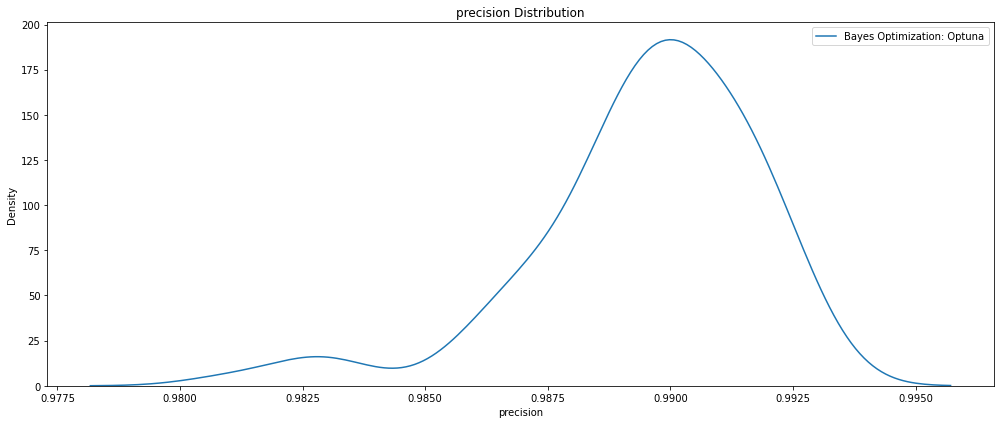

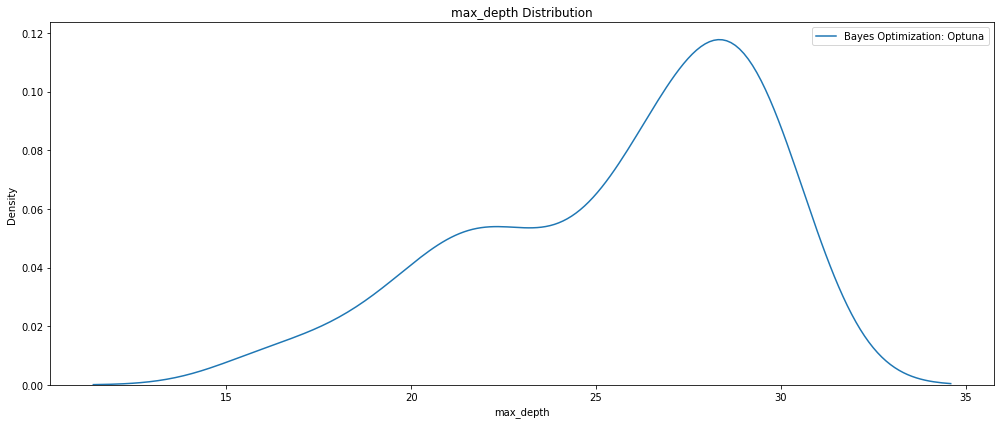

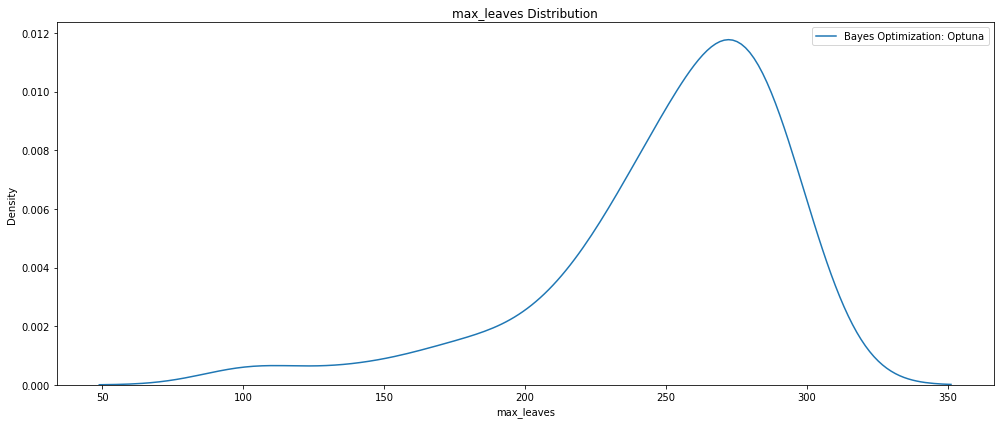

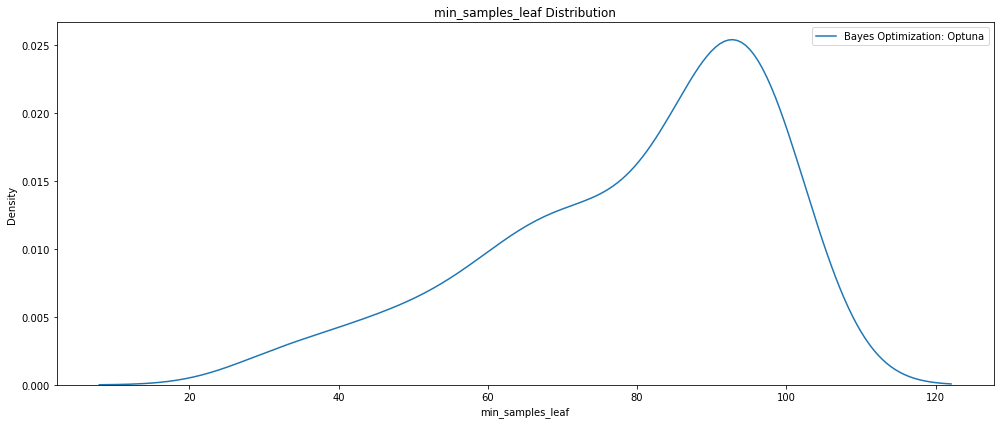

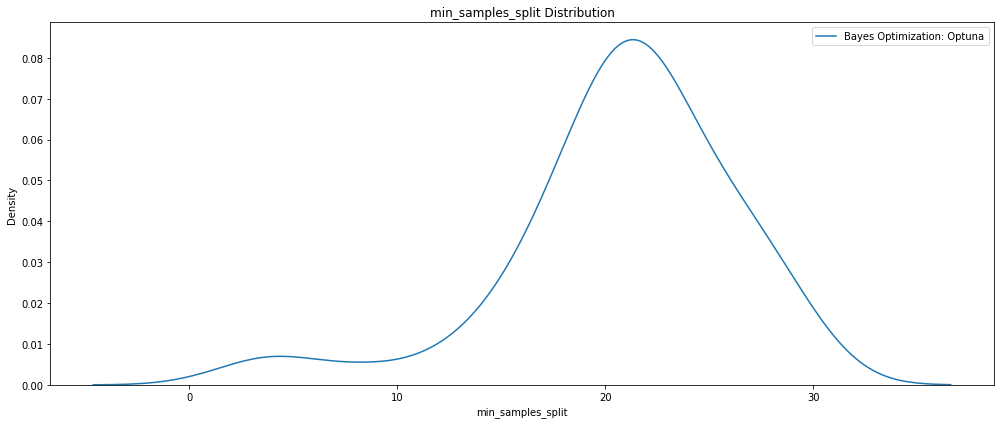

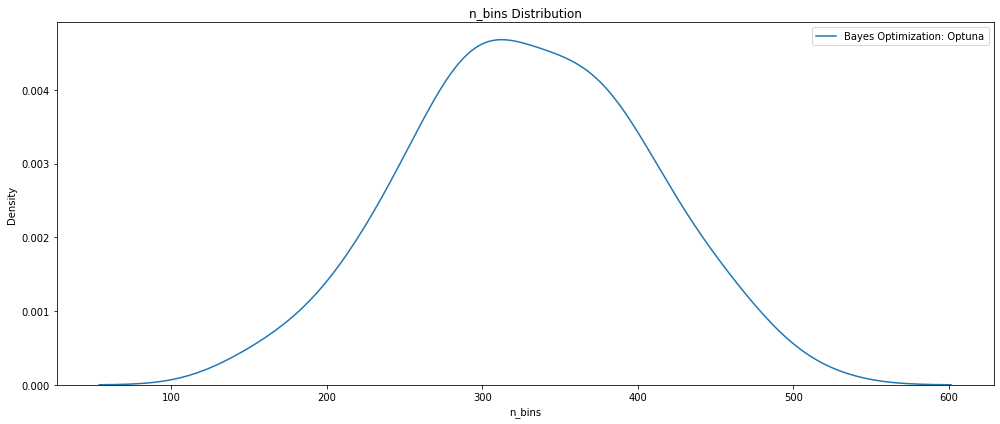

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

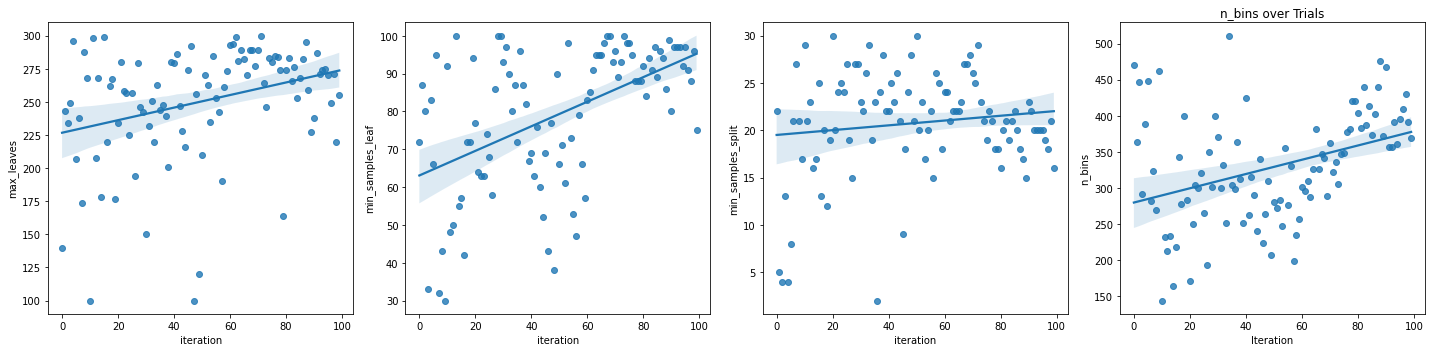

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_SMOTE_100_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 27,
 'max_leaves': 287,
 'min_samples_leaf': 97,
 'min_samples_split': 22,
 'n_bins': 357,
 'n_estimators': 121,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_SMOTE_trials100_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_SMOTE_trials100_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO SMOTE 100trials GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for RF HPO SMOTE 100trials GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    377848
           1       0.99      0.71      0.83     54625

    accuracy                           0.96    432473
   macro avg       0.98      0.85      0.90    432473
weighted avg       0.96      0.96      0.96    432473



Confusion matrix:
[[377572    276]
 [ 15879  38746]]


Accuracy score : 0.963
Precision score : 0.993
Recall score : 0.709
F1 score : 0.827


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 100 Precision GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 100 Precision GPU trials optimization scores 0.85429 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                    91
precision                              0.992927
datetime_start       2022-06-14 15:11:48.099539
datetime_complete    2022-06-14 15:12:21.893901
duration                 0 days 00:00:33.794362
max_depth                                    27
max_leaves                                  287
min_samples_leaf                             97
min_samples_split                            22
n_bins                                      357
n_estimators                                121
state                                  COMPLETE
Name: 91, dtype: object


In [ ]:
################################################################################
######################      Precision Score       ##############################
######################         300 Trials         ##############################
################################################################################
# Define a name for the trials
study_name = 'dask_rf_optuna_SMOTE_300_Precision_tpe'

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Define objective function with the parameters to be tested
def objective(trial, X_param, y_param):

    joblib.dump(study, 'RF_Optuna_SMOTE_300_GPU_Precision.pkl')

    # Search parameters
    n_estimators = trial.suggest_int('n_estimators', 250, 500) 
    max_depth = trial.suggest_int('max_depth', 25, 50) 
    max_leaves = trial.suggest_int('max_leaves', 250, 500) 
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 80, 150)
    min_samples_split = trial.suggest_int('min_samples_split', 5, 20) 
    n_bins = trial.suggest_int('n_bins', 400, 700)
    
    score = train_and_eval(X_param,
                           y_param,
                           bootstrap=True, 
                           n_estimators=n_estimators,
                           max_depth=max_depth,
                           max_leaves=max_leaves, 
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split, 
                           n_bins=n_bins)

    return score

In [ ]:
with timed('dask_optuna'):
    # Begin HPO trials 
    # Start timer for experiment
    start_time = datetime.now()
    print('%-20s %s' % ('Start Time', start_time))
    if os.path.isfile('RF_Optuna_SMOTE_300_GPU_Precision.pkl'): 
      study = joblib.load('RF_Optuna_SMOTE_300_GPU_Precision.pkl')
    else: 
      study = optuna.create_study(sampler=optuna.samplers.TPESampler(), 
                                  study_name=study_name,
                                  direction='maximize')
      
    # Optimize in parallel on Dask cluster
    with parallel_backend('dask'):
        study.optimize(lambda trial: objective(trial, X_train, y_train), 
                       n_trials=300,
                       n_jobs=n_workers)

# End timer for experiment
end_time = datetime.now()
print('%-20s %s' % ('Start Time', start_time))
print('%-20s %s' % ('End Time', end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Highest Precision score', study.best_value)

Start Time           2022-06-14 22:44:08.443132
- Trial time: 78.52760902499995
- Trial precision score: 0.9927464474922019
######################################################
- Trial time: 76.76544851100016
- Trial precision score: 0.9924428305034841
######################################################
- Trial time: 80.23094633000005
- Trial precision score: 0.9928403900752993
######################################################
- Trial time: 72.69796313699999
- Trial precision score: 0.993211000147587
######################################################
- Trial time: 137.5288176649999
- Trial precision score: 0.9920490797546012
######################################################
- Trial time: 75.29529926699979
- Trial precision score: 0.991734929121499
######################################################
- Trial time: 75.50203064100015
- Trial precision score: 0.9918960732791434
######################################################
- Trial time: 71.40195006399972
- Tri

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'precision'},inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_max_leaves':'max_leaves'}, inplace=True)
trials_df.rename(columns={'params_min_samples_leaf':'min_samples_leaf'}, inplace=True)
trials_df.rename(columns={'params_min_samples_split':'min_samples_split'}, inplace=True)
trials_df.rename(columns={'params_n_bins':'n_bins'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)

trials_df = trials_df.sort_values('precision', ascending=False)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('RF_Optuna_SMOTE_300_GPU_Precision.csv', index=False)

     iteration  precision             datetime_start  \
117        117   0.994051 2022-06-14 21:05:38.892983   
200        200   0.994015 2022-06-14 23:57:49.686363   
52          52   0.993982 2022-06-14 19:25:06.914915   
218        218   0.993891 2022-06-15 00:22:09.107315   
264        264   0.993777 2022-06-15 01:28:39.283369   
..         ...        ...                        ...   
49          49   0.988019 2022-06-14 19:20:27.617725   
9            9   0.987707 2022-06-14 18:21:29.676220   
0            0        NaN 2022-06-14 17:43:32.627660   
128        128        NaN 2022-06-14 21:19:25.162387   
144        144        NaN 2022-06-14 22:16:22.339519   

             datetime_complete               duration  max_depth  max_leaves  \
117 2022-06-14 21:06:54.018507 0 days 00:01:15.125524       40.0       490.0   
200 2022-06-14 23:59:06.850646 0 days 00:01:17.164283       44.0       495.0   
52  2022-06-14 19:26:20.098691 0 days 00:01:13.183776       50.0       500.0   
218 202

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_RF_Optuna_SMOTE_300_GPU_Precision.html')
fig.show()

In [ ]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_RF_Optuna_SMOTE_300_GPU_Precision.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_RF_Optuna_SMOTE_300_GPU_Precision.html')
fig.show()

In [ ]:
# plot_contour: plots parameter interactions on an interactive chart. 
fig = optuna.visualization.plot_contour(study, params=['max_leaves', 
                                                       'min_samples_leaf',
                                                       'max_depth', 
                                                       'min_samples_split'])
py.plot(fig, filename='contour_RF_Optuna_SMOTE_300_GPU_Precision.html')
fig.show()

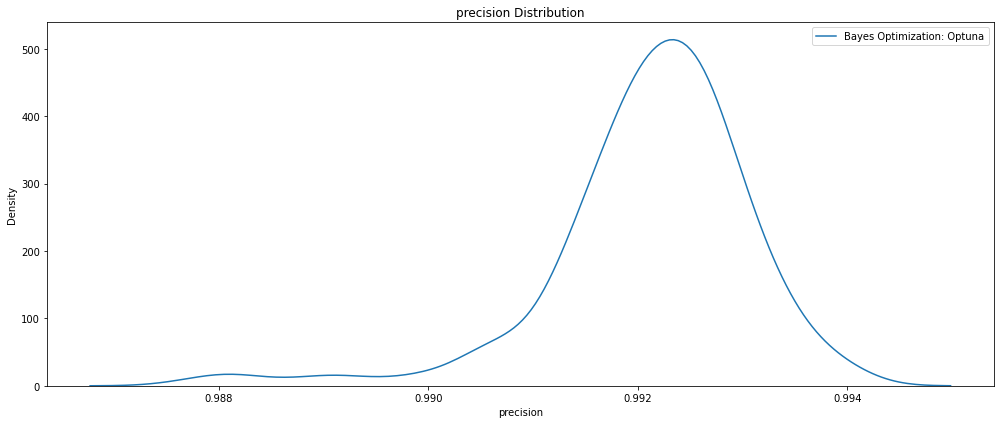

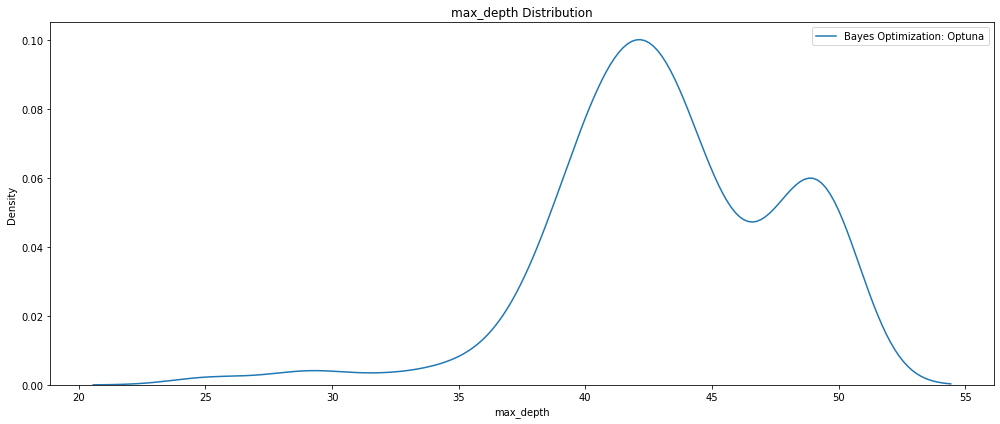

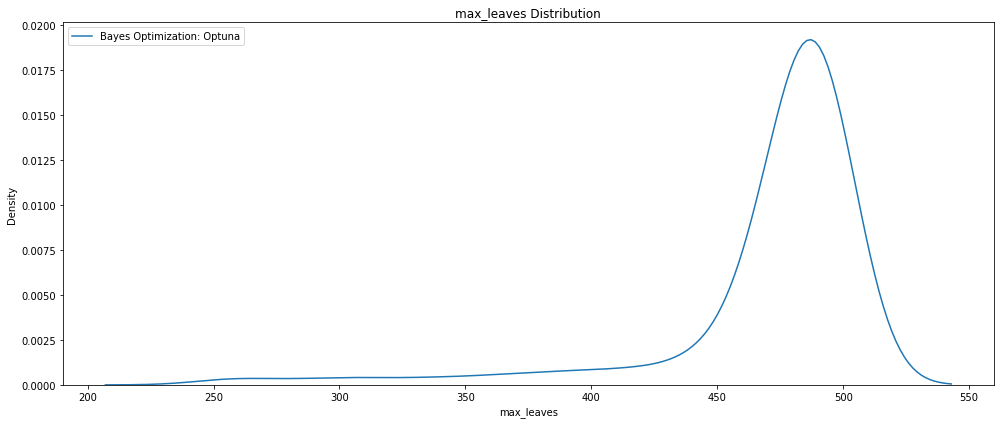

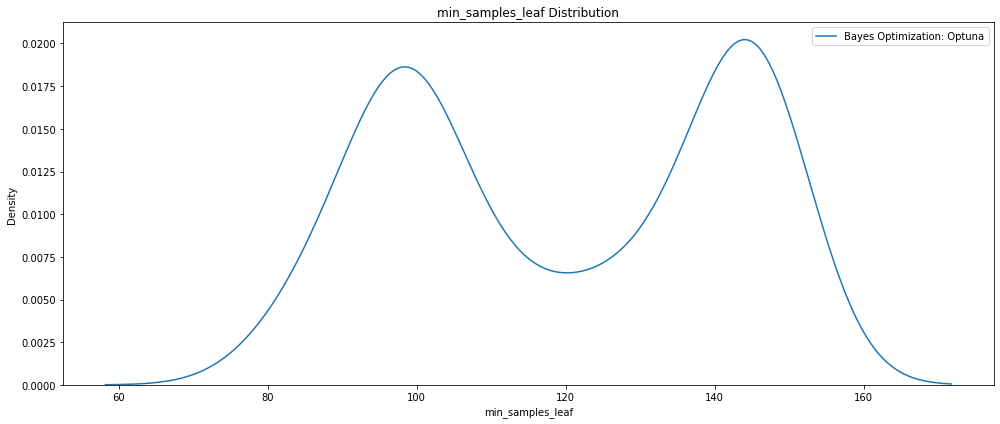

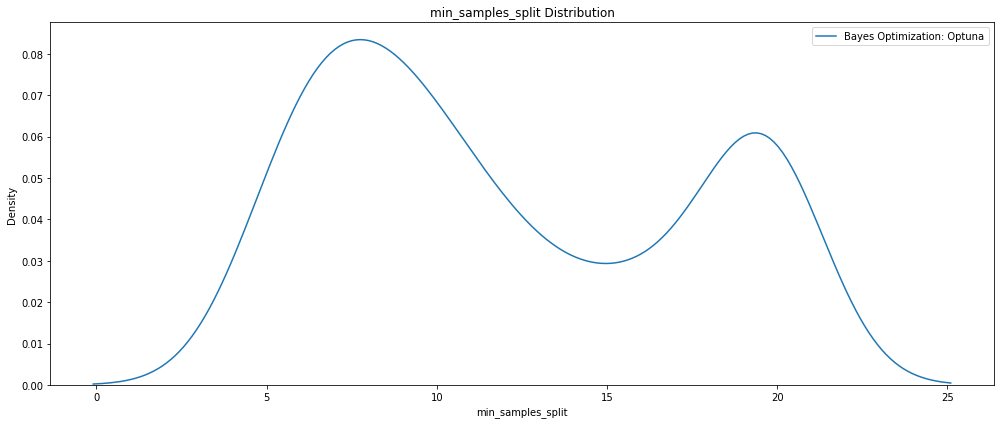

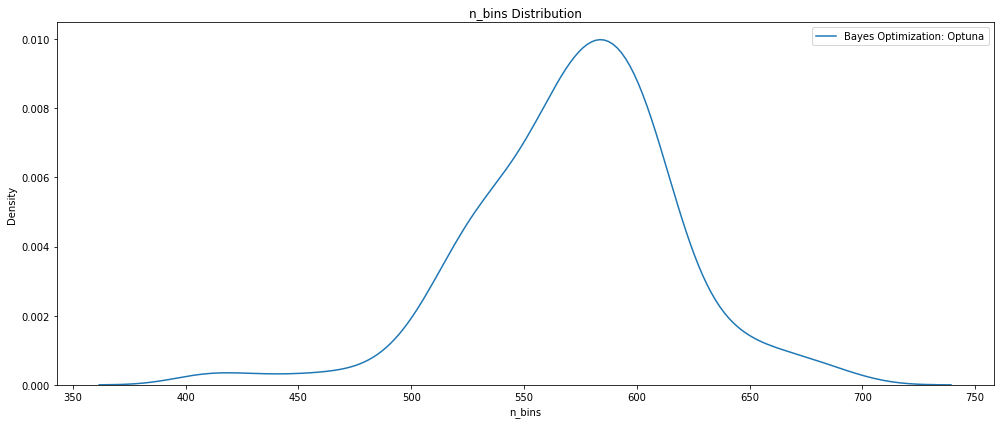

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

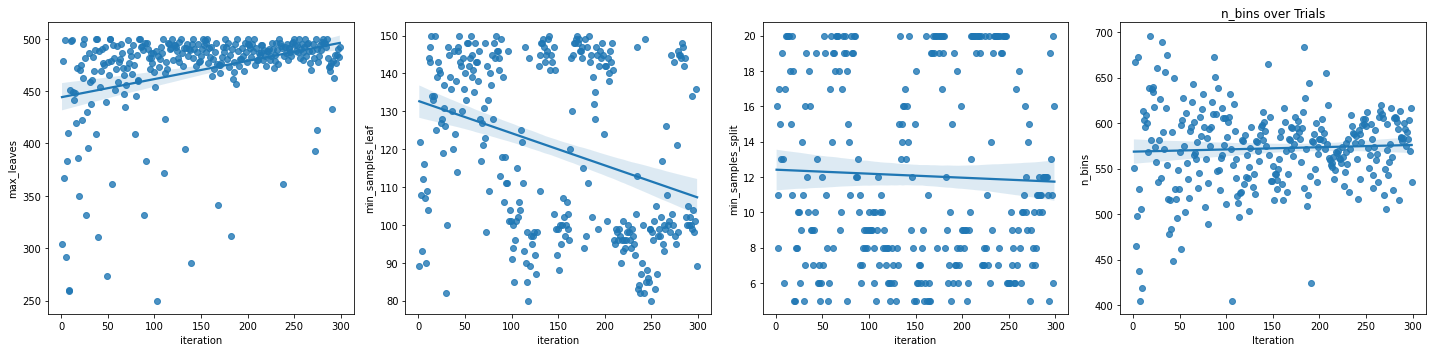

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 4, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['max_leaves', 'min_samples_leaf', 'min_samples_split',
                         'n_bins']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_RF_Optuna_SMOTE_300_GPU_Precision.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_RF_Optuna_SMOTE_300_GPU_Precision.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params

{'max_depth': 40,
 'max_leaves': 490,
 'min_samples_leaf': 98,
 'min_samples_split': 8,
 'n_bins': 581,
 'n_estimators': 255,
 'random_state': 42}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL/

/content/drive/MyDrive/LoanStatus/ML/RF/Optuna/Model_PKL


In [ ]:
# Set up train/test split
X_train, y_train = trainDF.drop('loan_status', axis=1), trainDF['loan_status'].astype('int32')
X_test, y_test= testDF.drop('loan_status', axis=1), testDF['loan_status'].astype('int32')

In [ ]:
X_train = cudf.get_dummies(X_train, columns=cat_cols)
X_train = X_train.astype('float32')

In [ ]:
X_test = cudf.get_dummies(X_test, columns=cat_cols1)
X_test = X_test.astype('float32')

In [ ]:
# Re-create the best model and train on the training data
best_model = RandomForestClassifier(n_streams=1, 
                                    **params)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'RF_Optuna_SMOTE_trials300_GPU_Precision.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('RF_Optuna_SMOTE_trials300_GPU_Precision.pkl')
# print(model)
# =============================================================================

In [ ]:
print('\nModel Metrics for RF HPO SMOTE 300trials GPU Precision')
# Predict based on training 
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report:')
clf_rpt = classification_report(y_test.to_numpy(), y_test_pred.to_numpy())
print(clf_rpt)
print('\n')
print('Confusion matrix:')
print(confusion_matrix(y_test.to_numpy(), y_test_pred.to_numpy()))
print('\n')
print('Accuracy score : %.3f'%accuracy_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Precision score : %.3f'%precision_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('Recall score : %.3f'%recall_score(y_test.to_numpy(), y_test_pred.to_numpy()))
print('F1 score : %.3f'%f1_score(y_test.to_numpy(), y_test_pred.to_numpy()))


Model Metrics for RF HPO SMOTE 300trials GPU Precision


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    377848
           1       0.99      0.74      0.85     54625

    accuracy                           0.97    432473
   macro avg       0.98      0.87      0.91    432473
weighted avg       0.97      0.97      0.96    432473



Confusion matrix:
[[377607    241]
 [ 14358  40267]]


Accuracy score : 0.966
Precision score : 0.994
Recall score : 0.737
F1 score : 0.847


In [ ]:
# Evaluate on the testing data 
print('The best model from SMOTE 300 Precision GPU trials optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test.to_numpy(), y_test_pred.to_numpy())))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from SMOTE 300 Precision GPU trials optimization scores 0.86826 AUC ROC on the test set.
This was achieved using these conditions:
iteration                                   117
precision                              0.994051
datetime_start       2022-06-14 21:05:38.892983
datetime_complete    2022-06-14 21:06:54.018507
duration                 0 days 00:01:15.125524
max_depth                                  40.0
max_leaves                                490.0
min_samples_leaf                           98.0
min_samples_split                           8.0
n_bins                                    581.0
n_estimators                              255.0
state                                  COMPLETE
Name: 117, dtype: object
